In [ ]:
!unzip train_images.zip

In [ ]:
!unzip test_images.zip

# Trabalho Prático **VCPI** (Visão por Computador e Processamento de Imagem)
## Modelos de *Deep Learning* aplicados ao *dataset* **GTSRB**

Pretende-se, neste *Python notebook*, aplicar um ou mais modelos *CNN*
(Convolutional Neural Network), para classficar um *dataset* de teste
com imagens (no âmbito do paradigma de visão por computadores);
considerando que estas redes são construídas, de modo, a aprender e
extrair informação sobre *features* diretamente de *raw pixel data*.

Adicionalmente, no paradigma de processamento de imagem,
pretende-se aplicar técnicas para *data augmentation*,
de modo a aumentar a *accuracy* do modelo;
aplicando transformações/modificações ao *dataset* de treino
para aumentar a diversidade e *performance* do modelo de aprendizagem.


#### Imports

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU, ReLU, BatchNormalization, Conv2D, MaxPooling2D, \
            Dense, Activation, Flatten, Dropout, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import glob

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd


# to determine the most voted
import collections

### Funções auxiliares para demonstrar imagens

In [4]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols)
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols


    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):

        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()
    plt.show()


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


def show_accuracies(labels, test, val):

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1-00, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()



def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):

    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(8,6))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()


### Definição dos *paths*

Colocar os paths para o *dataset* com as imagens (*data_path*) e o que servirá para guardar os ficheiros de *logging* (*log_and_model_path*).

**Cada um a testar o notebook deverá colocar os seus repetivos paths desejados.**

In [42]:
train_path = 'GTSRB/Final_Training/Images'
test_path = 'test_images/test'
data_png_train = 'png/train/'
data_png_test = 'png/test/'
log_and_model_path = 'dl04/'
WEIGHT_FILE_PREFIX = 'dl06/model_'

### Definição do tamanho do batch e das imagens

Considerando que estamos a utilizar o *tensorflow* recorrendo
à *GPU*, o poder de processamento será elevado.
Como queremos aproveitar melhor o paralelismo do *hardware*,
utilizamos um tamanho para as *batches* maior do que o normal;
de 64.
Adicionalmente, tamanhos mais pequenos podem levar a
uma convergência mais lenta ou em estimativas de gradiente ruidosas;
pelo que monitorizamos as curvas de aprendizagem do modelo final
para avaliar.

As imagens considerou-se 32 por 32 um tamanho razoável.

In [7]:
BATCH_SIZE = 64
IMG_SIZE = 32

### Converter ppm em png

Os *datasets* encontram-se ambos no formato *.ppm*;
*Portable Pixmap* é um formato de imagem amplamente utilizado para armazenar imagens *bitmap*, representando imagens em mapas de *bits* com informações de cores para cada píxel individual.

O formato *PPM* é um formato simples e legível por humanos, que armazena informações sobre largura, altura e valor máximo de cor, seguidos pelos valores de cor de cada pixel da imagem.

Contudo, para as nossas transformações, respetivo treino e previsões preferiu-se
utilizar o formato *PNG*, mais digerível pelos métodos fornecidos pela biblioteca *tensorflow*; para além de nos permitir visualizar as *batches* de imagens.

In [8]:
# Recursive function to convert PPM files to PNG format
def convert_ppm_to_png(directory, output):
    for filepath in glob.iglob(directory + "/**/*.ppm", recursive=True):
        im = Image.open(filepath)
        relative_path = os.path.relpath(filepath, directory)
        output_directory = os.path.join(output, os.path.dirname(relative_path))
        os.makedirs(output_directory, exist_ok=True)
        output_filepath = os.path.join(output_directory, os.path.splitext(os.path.basename(filepath))[0] + ".png")
        im.save(output_filepath)

# Call the function on the top-level directory - training data
convert_ppm_to_png(train_path, f'{data_png_train}')

# For the test data
convert_ppm_to_png(test_path, f'{data_png_test}')

### Load do dataset (Treino)

Ao contrário das aulas teorico-práticas, nas quais o professor recorreu
a funções de processamento de imagens arbitrárias para realizar o *data augmentation*, no nosso *notebook* será através da classe *ImageDataGenerator*.

A classe *ImageDataGenerator* da biblioteca *TensorFlow* é uma ferramenta útil para pré-processamento e *data augmentation* durante o treino de modelos de aprendizagem profunda (*deep learning*). Permite gerar *batches* de dados (de imagem) em tempo real, aplicando uma variedade de transformações e técnicas de *data augmentation*.
A classe *ImageDataGenerator* oferece uma interface conveniente para realizar as essas operações.

Sendo assim, o *loading*, *resizing* das imagens e o *batching* é realizado a partir da função ```flow_from_directory```, aplicando-se as transformações com as quais a classe foi inicializada.

Deste modo, cria-se um gerador de dados que pode ser usado para alimentar o modelo durante o treino.
A cada *epoch*, o gerador de dados gera *batches* de imagens com base nas configurações fornecidas, aplicando as transformações aleatórias especificadas. Permite, então, que o modelo veja diferentes versões das mesmas imagens a cada *epoch*, melhorando a sua capacidade de generalização.

Pode-se aplicar transformações como:
1. Rotações;
2. *Shifts*;
3. *Zooms*;
4. *Flipping*;
5. entre outras.

Deste modo, está-se a gerar dados *augmented* de um modo mais eficiente e rápido; para o treino da rede neural (CNN).
Colocou-se o *shuffle* a verdadeiro, para trazer mais aleatoriedade
para a organização dos *batches* (ser menos previsível).
E para ambos os *datasets* o pré-processamento correspondeu à sua **normalização**.

As transformações serão apenas aplicadas depois de apresentar os três modelos criados (de diferentes níveis de complexidade); sendo que este inicio e para demonstrar o que se irá utilizar mais à frente (para aplicar *data augmentation* nos dados).

In [9]:
# Gerador (A inicial aplica unicamente normalização - rescale)
datagen = ImageDataGenerator(
    rescale=1./255
)

In [10]:
# Labels para as imagens (nomes das subdiretorias)
classNames = np.array(os.listdir(data_png_train))

trainset = datagen.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


### Realizar o *printing* de dados importantes (e computar tamanho do *dataset*)

A forma (64, 32, 32, 3) representa a forma das imagens de *input* num *batch* do conjunto de dados. As dimensões representam:

- (64): Indica que há 64 imagens no *batch*. O tamanho do *batch* foi definido como 64 ao definir o gerador trainset com o parâmetro batch_size.

- (32, 32): Representa as dimensões espaciais de cada imagem no *batch*. Neste caso, cada imagem tem uma altura e largura de 32 pixels.

- (3): Corresponde ao número de canais de cor em cada imagem. Como as imagens são imagens RGB, o valor é 3, indicando que existem três canais de cor (vermelho, verde e azul).

Portanto, a forma (64, 32, 32, 3) indica que o *batch* contém 64 imagens, cada uma com um tamanho espacial de 32x32 pixels e três canais de cor.

Da mesma forma, a forma (64, 43) para (t[1].shape) representa a forma das *labels* correspondentes às imagens no *batch*.
A primeira dimensão 64 indica que há 64 *labels* no *batch* (um para cada imagem), e a segunda dimensão 43 indica o número de classes ou categorias nas quais as imagens são classificadas. Neste caso, existem 43 classes diferentes.

Por fim, a linha Total images in dataset: 613 indica que o número total de imagens no conjunto de dados é 613. Essa informação é obtida a partir da função len(trainset), que retorna o número total de *batches* no conjunto de dados. Como cada *batch* tem um tamanho de 64 (conforme definido em BATCH_SIZE), multiplicar o tamanho do *batch* pelo número de *batches* fornece o número total de imagens no conjunto de dados.

In [11]:
t = next(iter(trainset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = len(trainset)
print("Total images in dataset: ", dataset_length)

(64, 32, 32, 3) (64, 43)
Total images in dataset:  613


### Demonstração do primeiro batch (para efeitos de visualização)

Visualização de uma *batch*, com as respetivas classes (*labels*).

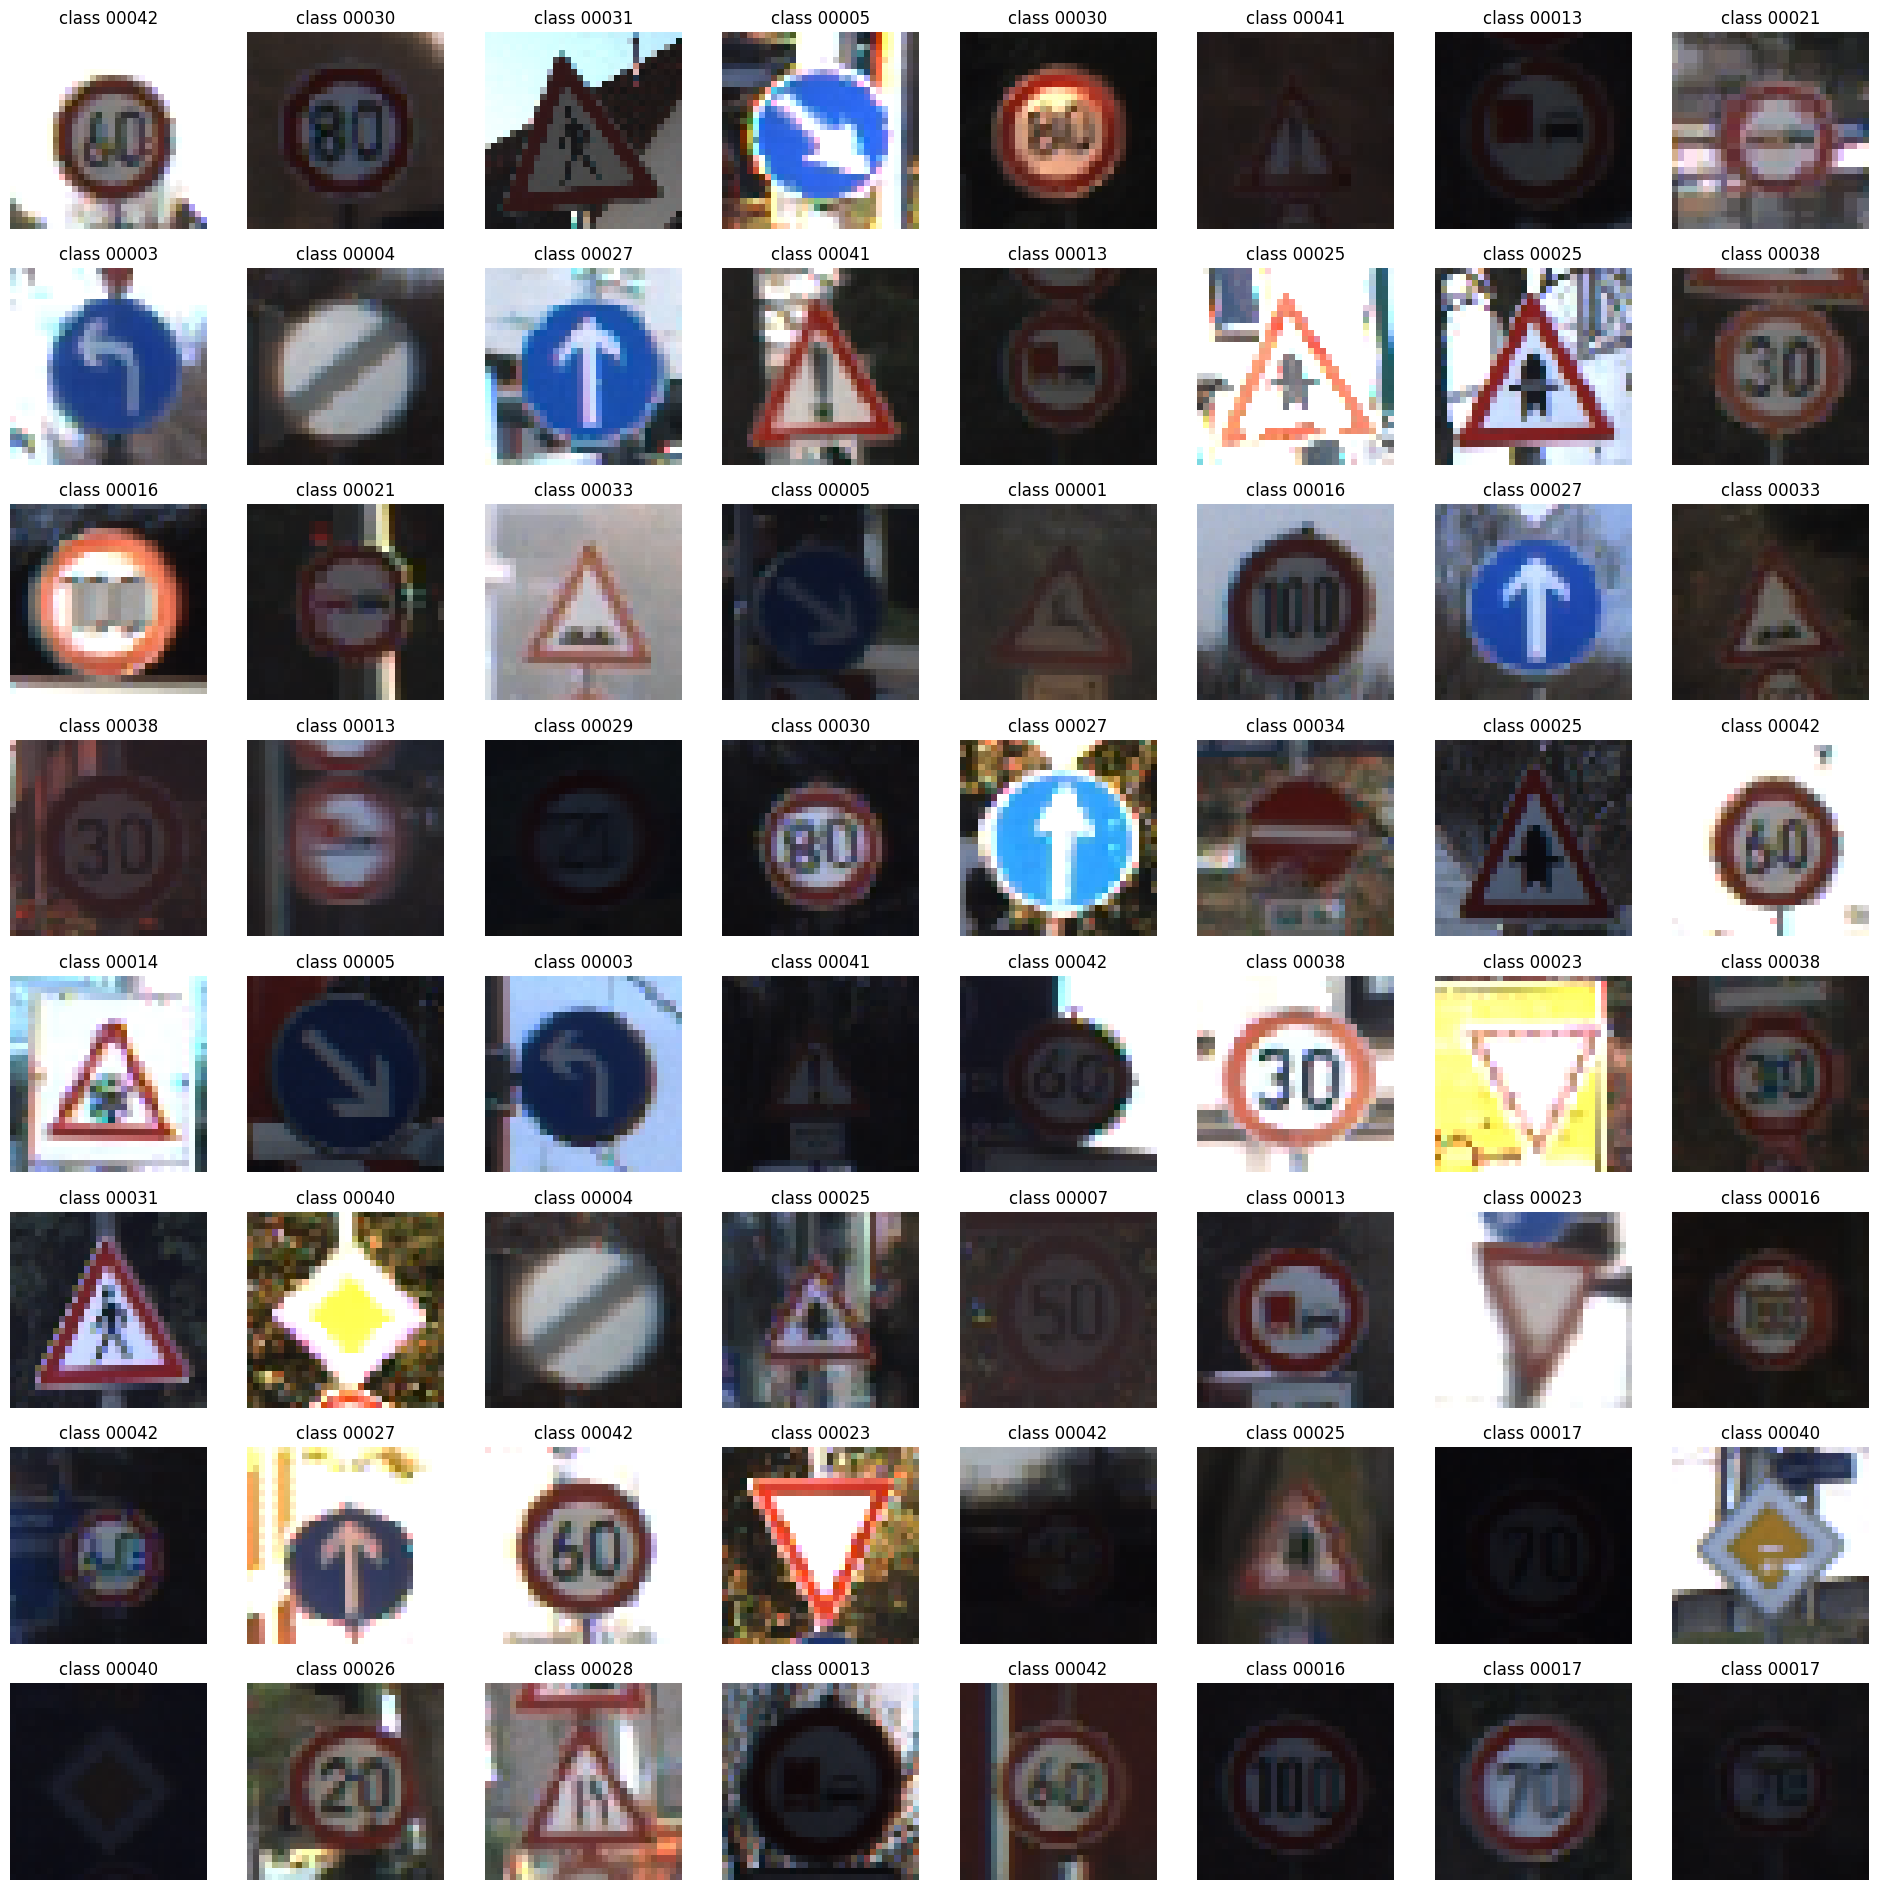

<Figure size 640x480 with 0 Axes>

In [12]:
image_batch, label_batch = next(iter(trainset))
show_batch(8,image_batch, label_batch)

### Preparação do *dataset* de teste

Neste caso, como se trata do *dataset* de teste, apenas se aplicou um pré-processamento de imagens, com **normalização**.

Como não serão aplicadas transformações, uma vez que se trata do *dataset* de teste, utilizou-se o método ```image_dataset_from_directory``` do *keras* para criar um *dataset* do *Tensorflow* para o *dataset* de teste.

Neste caso, a normalização é para manter ambos os *datasets*, de teste e de treino, com os dados na mesma escala, as **imagens**.

In [13]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    data_png_test,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle = True)

normalize = tf.keras.layers.Rescaling(1.0/255)
testset = testset.map(lambda x, y: (normalize(x), y))

Found 12630 files belonging to 43 classes.


### Mostrar uma batch dos dados do dataset de treino

Visualização de uma *batch*, com as respetivas classes (*labels*).

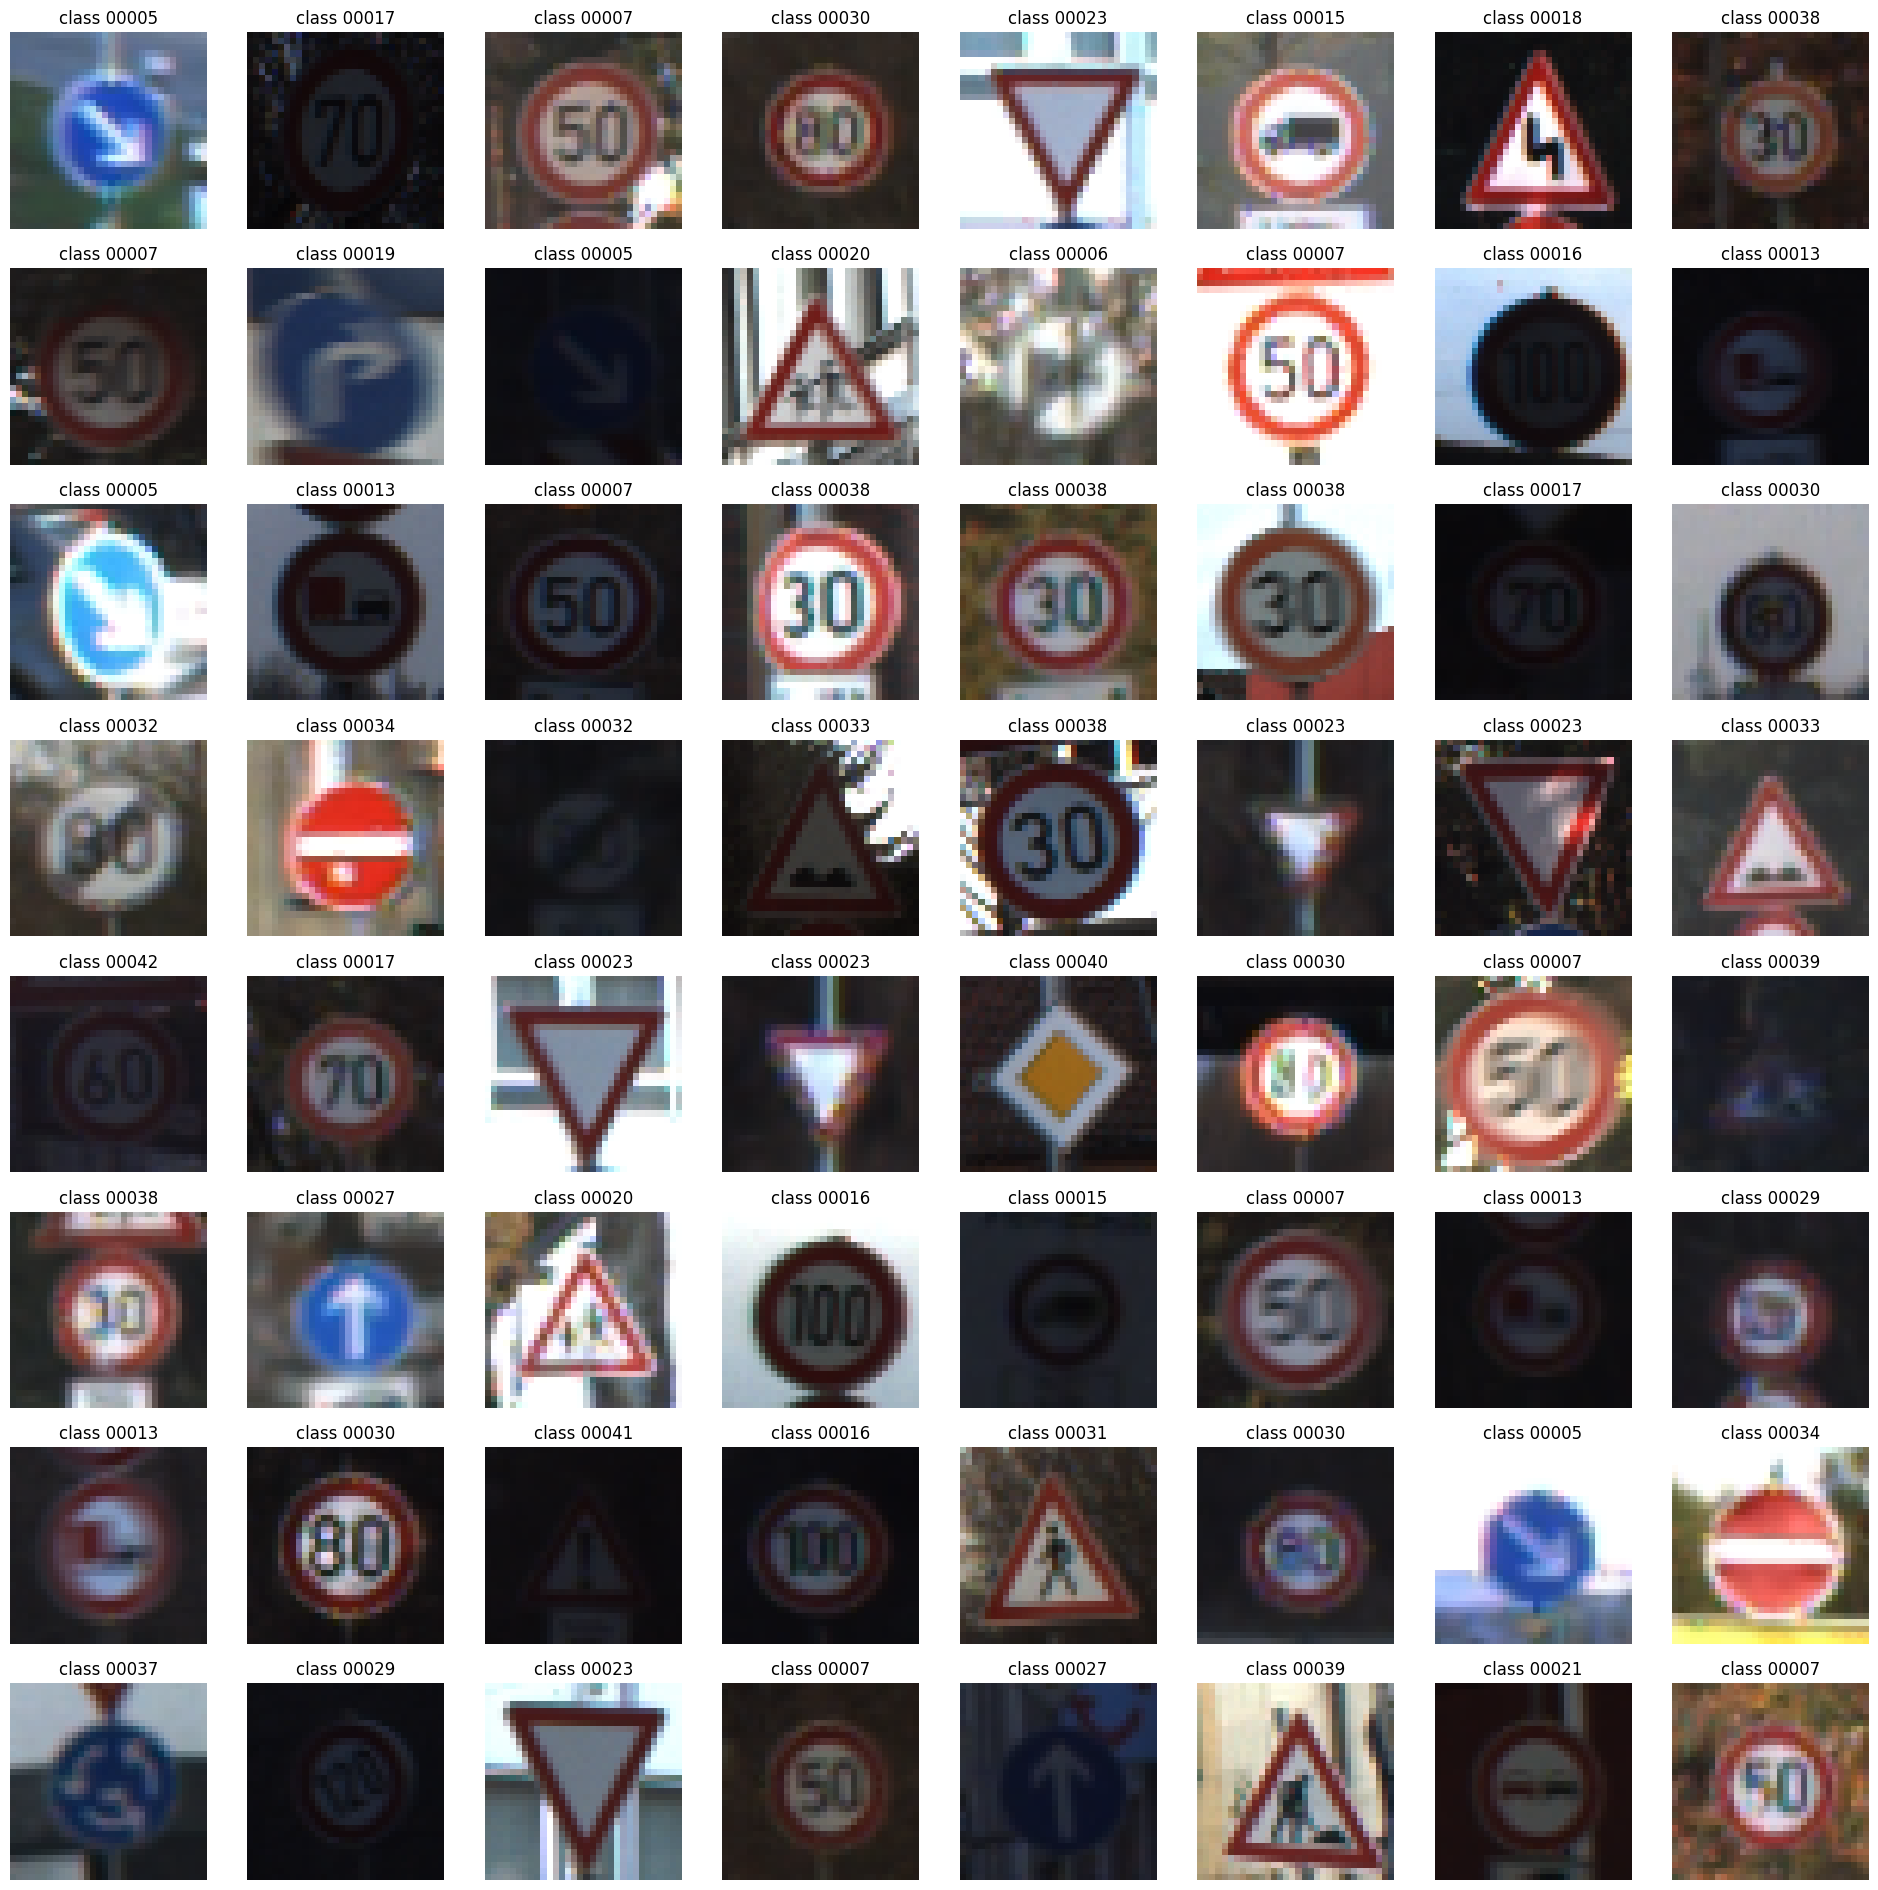

<Figure size 640x480 with 0 Axes>

In [14]:
image_batch, label_batch = next(iter(testset))
show_batch(8,image_batch, label_batch.numpy())

### Função de Callbacks

A função ```prepareCallbacks(path)``` é responsável por configurar e retornar diversos *callbacks* do *Keras* que podem ser utilizados durante o treino de um modelo de aprendizagem.

Explicitando cada um dos *callbacks*, temos:
1. ```ModelChackpoint```:  Responsável por salvar os pesos do modelo num arquivo de *checkpoint*. Recebe o caminho para onde o arquivo será guardado (filepath), a métrica a ser monitorizada para determinar se o modelo melhorou na aprendizagem (monitor), o nível de detalhe das mensagens (verbose); os dois finais indicam que serão apenas guardados os pesos do modelo, bem como unicamente os que tiveram os melhores valores.
2. ```EarlyStopping```> Utilizado para interromper o treino antecipadamente, caso não houver melhora na métrica a ser monitorizada, por um determinado número de *epochs* consecutivas. O parâmetro *min_delta* indica a diferença mínima considerada como melhoria na métrica a monitorizar e a *patience* será o número de *epochs* consecutivas sem nenhuma melhria que serão aceites (até interromper o treino).
3. ```Tensorboard```: Este *callback* é utilizado para gerar registos para visualização no *TensorBoard*, uma ferramenta de visualização fornecida pelo *TensorFlow*; são passados a diretoria onde são guardados os registos (*log_dir*), a frequência com que os histogramas das ativações são calculados e
variáveis booleanas a confirmar que vão ser guardados gráficos computacionais nos registos, bem como imagens das camadas do modelo.
4. `ReduceLROnPlateau`:  Esse callback é utilizado para reduzir a taxa de apredizagem (*learning rate*) do *optimizer* quando a melhoria na métrica a ser monitorizada diminui. Neste caso, temos o fator de redução do *learning rate* (new_learning_rate = prev_learning_rate * factor), o número de **epochs* consecutivas sem melhorias que levarão à redução do *learning rate* (patience) e, por fim, o limite inferior para o *learning rate* (min_lr).

Neste caso, repara-se que a métrica escolhia é sempre **val_loss**.

A escolha da métrica *val_loss* é, normalmente, feita quando trata-se de um modelo de aprendizagem para resolver um problema de otimização, como classificação ou regressão; sendo no nosso caso um problema de classificação.

O *val_loss* refere-se à perda (*loss*) do modelo durante a fase de validação, ou seja, a perda calculada usando um conjunto de dados de validação separado que não é usado para treinar o modelo (o nosso *dataset* de teste). A perda mede o quão bem o modelo está se ajustando aos dados durante o treino; sendo o objetivo minimizar essa perda.

Ao monitorizar a *val_loss*, estamos acompanhando a capacidade do modelo de generalizar a aprendizagem para novos dados que não foram vistos durante o treino. Se a *val_loss* começar a aumentar ou parar de diminuir, pode ser um sinal de que o modelo está começando a sofrer de *overfitting*, ou seja, está se ajustando muito bem aos dados de treino específicos, mas não está generalizando bem para novos dados.

Portanto, escolher *val_loss* como métrica a ser monitorada nos callbacks, como no caso do `EarlyStopping` e `ModelCheckpoint`, permite interromper o treino antecipadamente se a perda de validação parar de diminuir, evitando o *overfitting*, e também salvar os pesos do modelo correspondentes à melhor perda de validação alcançada até o momento.

In [15]:
def prepareCallbacks(path):
    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath=file_path,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_weights_only=True,
                                   save_best_only=True)

    earlyStopper = EarlyStopping(monitor='val_loss',
                                 min_delta=0.001,
                                 patience=8,
                                 verbose=1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log',
                             histogram_freq=0,
                             write_graph=True,
                             write_images=True)

    reduceLR = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=3,
                                verbose=1,
                                min_lr=0.00001)

    return file_path, [checkpointer, earlyStopper, tbCallBack, reduceLR]

# Definição dos modelos para aprendizagem

Encontram-se, de seguida, a definição e respetivo treino/validação dos *datasets* de três modelos diferentes; com diferentes definições, desde a mais simples à mais complexa, sendo que foram feitas alterações para obter os melhores resultados possíveis (antes de se aplicar qualquer data augmentation).

Considerou-se que os valores para a respetiva accuracy/val_accuracy, loss/val_loss do último modelo eram um ponto de partida bom o suficiente como um modelo de aprendizagem (especialmente com base na observação das repetivas curvas para accuracy e loss, que representam um bom *fit*).

Cabe agora encontrar as melhores transformações a aplicar no modelo que permite aumentar o valor dado, ou mesmo melhorar performance.

Sendo assim, apresenta-se cada um dos modelos criados, no fluxo da sua criação por parte do grupo; cada um sem qualquer *data augmentation*, para escolher o melhor sobre o qual vamos partir.

### Definição do 1º modelo (Com apenas *Conv layers*)

Para um primeiro modelo, recorreu-se aos exemplos dos *notebooks* proporcionados pela equipa docente; um exemplo simples para entender o estado do treino/validação do modelo, num contexto básico.

Sendo assim:

1. Como todos os modelos, é criado um modelo **sequencial**, que permite construir uma pilha linear de camadas (`Sequential()`);
2. É adicionada uma camada de *input* ao modelo, reprensentando o tipo de dados (imagens) que irá receber (**largura, altura** e **número de canais**);
3. Adiciona uma camada de convolução 2D ao modelo com 64 filtros e uma janela de convolução de tamanho (5, 5). A camada extrai recursos das imagens através de convolução. São criadas duas destas *hidden layers*;
4. Para cada uma delas é adicionada uma função de ativação `LeakyReLU()` (variação da função `ReLU()` que permite valores negativos);
5. A camada `Flatten()` converte o *output* das camadas convolucionais num **vetor unidimensional**, preparando os dados para serem alimentados nas camadas densamente conectadas;
6. É Adicionada uma camada densamente conectada com 128 unidades (`Dense()`);
7. A própria rede densamente conectada receberá uma função de ativação (`LeakyReLU()`);
8. Adiciona a camada de saída ao modelo com *classCount* unidades, correspondendo ao número de classes do problema. A ativação **'softmax'** é usada para obter probabilidades de cada classe;
9. Cria um otimizador Adam com uma taxa de aprendizagem de *0.001* (número testado arbitrariamente);
10. Compila o modelo, definindo o otimizador, a função de perda (categorical_crossentropy para classificação multiclasse) e as métricas (neste caso, apenas a *accuracy*).

O modelo é uma *CNN* composta por várias camadas convolucionais seguidas por camadas densamente conectadas.
É usada a função de ativação *LeakyReLU* para introduzir **não-linearidade** e uma camada de saída com ativação *softmax* para classificação multiclasse. A função de perda é a *categorical_crossentropy* e a métrica de avaliação é a *accuracy*.

Mais uma vez, este é um modelo básico, sendo que atualizações serão realizadas a partir dele, considerando os resulatados.


In [ ]:
def model_I(classCount, imgSize, channels):
    model = Sequential()

    model.add(Input(shape=(imgSize, imgSize, channels)))
    model.add(Conv2D(64, (5, 5)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5) ))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5) ) )
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(classCount, activation='softmax'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### Print do modelo e das suas características
É inicializada com o número de classes (43), tamanho da imagem (32) e o número de *channels* (3).

In [ ]:
modelV1 = model_I(43, 32, 3)

print(modelV1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        102464    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 flatten (Flatten)           (None, 25600)             0

### Preparar e treinar o modelo

Considerou-se **20** *epochs* um número bom para o modelo, considerando os early stoppings obtidos em *fits* sucessivos.

A partir da quarta *epoch*, tanto a *loss* quanto a *accuracy* de validação não melhoraram significativamente.
Indica-nos que o modelo pode ter atingido um limite no seu desempenho e não está melhorando mais com o treinamento adicional.

A partir da quarta *epoch*, também podemos observar a redução da taxa de aprendizagem (*learning rate*) devido ao uso do *callback ReduceLROnPlateau*.
Com isto, sabemos que o modelo está-se ajustando gradualmente à taxa de aprendizagem para buscar uma convergência mais precisa.

O treino foi interrompido na nona *epoch* devido ao uso do *callback EarlyStopping*. Tal ocorreu porque a perda de validação não melhorou por um período de 8 *epochs* consecutivas.

Com base nessas observações, podemos concluir que o modelo obteve um desempenho **geral** muito bom, alcançando alta *accuracy* tanto nos dados de treino quanto nos dados de validação.


In [ ]:
file_pathV1, callbacksV1 = prepareCallbacks('V1')

historyV1 = modelV1.fit(trainset,
                        epochs=20,
                        validation_data=testset,
                        callbacks=callbacksV1)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8888
Epoch 1: val_loss improved from inf to 0.24510, saving model to dl04//V1/cp.ckpt
613/613 [==============================] - 32s 49ms/step - loss: 0.4180 - accuracy: 0.8888 - val_loss: 0.2451 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 2/20
612/613 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9860
Epoch 2: val_loss did not improve from 0.24510
613/613 [==============================] - 31s 50ms/step - loss: 0.0526 - accuracy: 0.9860 - val_loss: 0.2460 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 3/20
612/613 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.9885
Epoch 3: val_loss did not improve from 0.24510
613/613 [==============================] - 34s 55ms/step - loss: 0.0419 - accuracy: 0.9885 - val_loss: 0.3642 - val_accuracy: 0.9478 - lr: 0.0010
Epoch 4/20
612/613 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9921
Epo

### Gráficos para *loss* e *accuracy*

Não obstante os bons valores óbtidos no final para a *accuracy* (**1.0**), *loss* (**4.3227e-05**), *val_accuracy* (**val_accuracy**) e *val_loss* (**0.3093**), ao observar os gráficos finais (de *accuracy* e *loss* ao longo das *epochs*), pode-se verificar que não houve muita variação nos resultados;
o que implica que o treino acabou muito cedo, e o modelo não aprendeu corretamente.

Consegue-se visualizar:

- No gráfico de *accuracy*, tem-se que a *accuracy* encontra-se muito boa, pelo que o modelo consegue perfeitamente classificar as imagens do *dataset* de treino. Por outro lado, na validação, apesar de no final ter um valor muito bom, consegue-se ver que após a primeira *epoch* não melhorou significamente (estagnou); o que pode significar que o modelo pode ter atingido um limite em sua capacidade de generalização.

- No gráfico de *loss*, tal como no de *accuracy*, revela que a *loss* no *dataset* de treino foi muito bom, encontrando-se em valores muito baixos. Por outro lado, na de validação, após a primeira *epoch*, a *val_loss* não melhorou muito, permancendo numa linha reta; o que pode indicar *overfitting*, onde o modelo se ajusta muito bem aos dados de treino, mas não consegue generalizar para novos dados (de teste).

Em resumo, uma perda de validação de *0.2450-0.3093* é razoavelmente baixa e indica um bom desempenho do modelo. No entanto, é importante avaliar o desempenho em conjuntos de teste independentes para ter uma compreensão completa da capacidade do modelo de fazer previsões precisas em dados não vistos anteriormente.
O que indica que o modelo não está a permitir a correta aprendizagem para os dados de teste.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


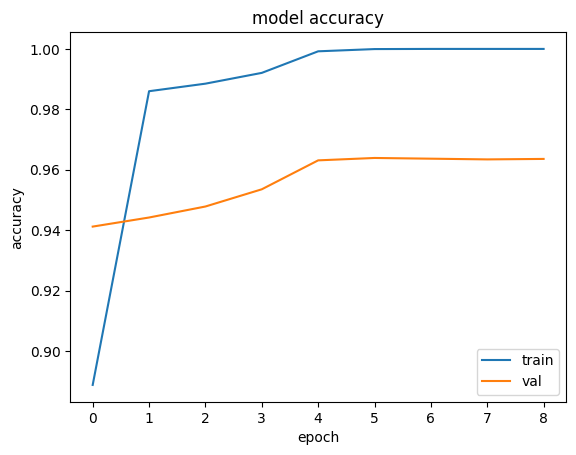

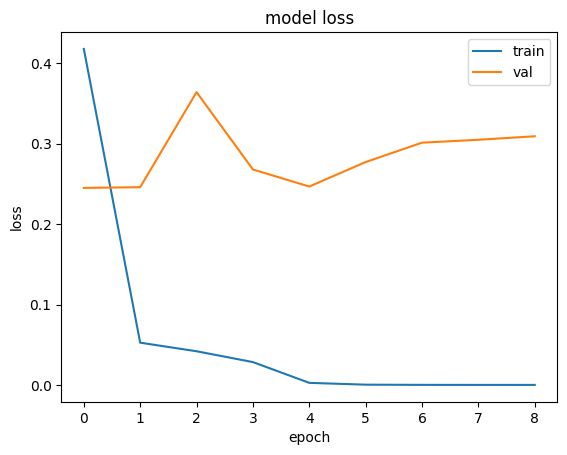

In [ ]:
show_history(historyV1)

In [ ]:
modelV1.load_weights(file_pathV1)

evalV1 = modelV1.evaluate(trainset, verbose=2)
print(evalV1)
valV1 = modelV1.evaluate(testset, verbose=2)
print(valV1)

613/613 - 23s - loss: 0.0583 - accuracy: 0.9873 - 23s/epoch - 37ms/step
[0.058347705751657486, 0.9873243570327759]
198/198 - 3s - loss: 0.2451 - accuracy: 0.9412 - 3s/epoch - 18ms/step
[0.24510334432125092, 0.9411718249320984]


#### Definição do 2º modelo (Com normalização, max pooling e dropout)

Partindo do 1º modelo criado, verificamos que estava a acontecer um caso de *overfitting*, pelo que seria o nosso trabalho melhorar a componenente de generalização do modelo.
A partir disto, adicionou-se três novas componentes:
1. `BatchNormalization()`: Adiciona-se camadas de normalização por *Batch* após cada camada convolucional. A *Batch normalization* ajuda a acelerar o treino, tornando os gradientes mais estáveis durante o processo de otimização; levando a uma convergência mais rápida e a um melhor desempenho do modelo. Ao normalizar as ativações, a *Batch Normalization* ajuda a estabilizar o treino da rede neural; reduz-se a dependência das atualizações dos pesos em relação às alterações nas ativações anteriores. Deste modo, o treino mais robusto e menos sensível a hiperparâmetros de inicialização.
Para além disso, atua como uma forma de regularização, ao introduzir um pequeno ruído durante o treino (reduzir o *overfitting*, especialmente em conjuntos de dados menores). Reduz-se a sensibilidade da rede em relação à inicialização dos pesos (têm menos impacto sobre o desempenho da rede, o que facilita a escolha de valores iniciais dos pesos.)
Por fim, permite que a rede neural seja treinada mais rapidamente; porque a normalização ajuda a evitar a saturação das funções de ativação e permite uma propagação mais suave dos gradientes durante o processo de retropropagação (**por este motivo tem uma camada de normalização após cada camada de convolução**).
2. `MaxPooling2D()`: São utilizadas camadas de *pooling* máximo após as camadas convolucionais. Estas ajudam a reduzir a dimensionalidade espacial do *output* das camadas convolucionais, preservando as características mais importantes. Isso pode melhorar a capacidade de generalização do modelo e reduzir o *overfitting*, ao fornecer uma forma de regularização e prevenção do aumento excessivo de parâmetros na rede neural. (O tamanho da janela foi escohido de modo a ser compatível com as dimensões das imagens em questão.)
3. `Dropout()`: Inclui-se, finalmente, uma camada de *Dropout* com uma taxa de *0.2* após a camada densa. O *Dropout* é uma técnica de regularização que desativa aleatoriamente uma fração dos neurônios durante o treino; ajudando a prevenir o *overfitting*, forçando o modelo a aprender representações mais robustas e independentes.

O nosso `model_II` adiciona *batch normalization*, camadas de *Max pooling 2D* e *Dropout*, que são técnicas comumente usadas para melhorar o desempenho e a capacidade de generalização de modelos de redes neurais convolucionais (e prevenir o *overfitting*). Essas melhorias podem levar a uma maior precisão e estabilidade durante o treinamento e teste do modelo.

In [ ]:
def model_II(classCount, imgSize, channels):
    model = Sequential()

    model.add(Input(shape=(imgSize, imgSize, channels)))

    model.add(Conv2D(64, (5, 5)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5) ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5) ) )
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))


    opt = Adam(learning_rate=0.001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

#### Print do modelo e das suas características
Como anteriormente, é inicializada com o número de classes (43), tamanho da imagem (32) e o número de channels (3).

In [ ]:
modelV2 = model_II(43, 32, 3)

print(modelV2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 64)       

#### *Fit* do modelo atualizado

Consegue-se visualizar que o modelo, neste caso, passa por todas as 20 épocas,
o que indica que existe uma probabilidade de precisar de mais para completamente aprender (com correção).

Contudo, o *fit* atual, com 20 *epochs* já demora bastante tempo, com uma média
de **31 segundos** por *epoch* (considerando que estamos a correr o modelo sob a *GPU*).

Outras alterações pode se fazer para permitir manter ou melhorar a performance,
sem haver a necessidade de alterar os valores das *epochs*.

In [ ]:
file_pathV2, callbacksM2 = prepareCallbacks('bestM2')

historyV2 = modelV2.fit(trainset,
          epochs=20,
          validation_data = testset,
          callbacks=callbacksM2)

Epoch 1/20
612/613 [============================>.] - ETA: 0s - loss: 0.5745 - accuracy: 0.8460
Epoch 1: val_loss improved from inf to 0.20169, saving model to dl04//bestM2/cp.ckpt
613/613 [==============================] - 34s 51ms/step - loss: 0.5737 - accuracy: 0.8462 - val_loss: 0.2017 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 2/20
612/613 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9781
Epoch 2: val_loss improved from 0.20169 to 0.19302, saving model to dl04//bestM2/cp.ckpt
613/613 [==============================] - 31s 51ms/step - loss: 0.0764 - accuracy: 0.9781 - val_loss: 0.1930 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9871
Epoch 3: val_loss improved from 0.19302 to 0.12780, saving model to dl04//bestM2/cp.ckpt
613/613 [==============================] - 30s 49ms/step - loss: 0.0449 - accuracy: 0.9871 - val_loss: 0.1278 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 4/20


### Avaliação gráfica dos resultados

Existe uma clara melhoria no aspeto das curvas para *loss* e *accuracy*, no caso do **modelo II**.
Cotude, verifica-se vários picos, em ambos os gráficos, o que comprova o anteriormente dito que o programa necessitava de mais *epochs* para treinar mais; pelo que o atual não tem dados representativos do *dataset* de teste que recebeu.
Neste caso, procurar-se-á melhorar este aspeto, tendo em consideração a performance do modelo também.

Contudo, não obstante este aspetos, o modelo continua a ter bons valores finais para todas métricas; ainda melhor que o primeiro (sendo este um ponto positivo de que encontramos-nos num bom caminho).
A *val_accuracy* acima de tudo, de **98.56%** encontra-se num valor bastante alto e a *accuracy* encontra-se bastante próxima de 1, sendo isto muito bom também.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


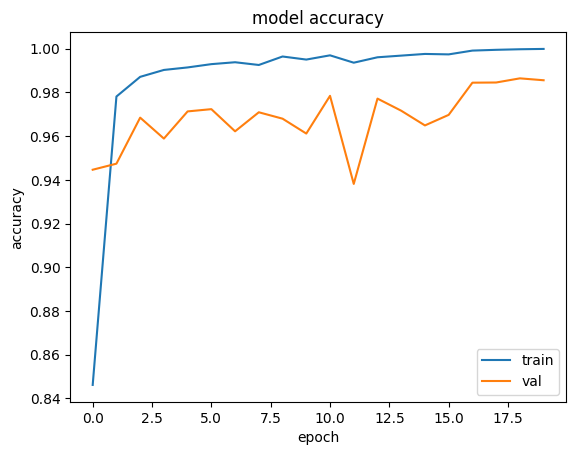

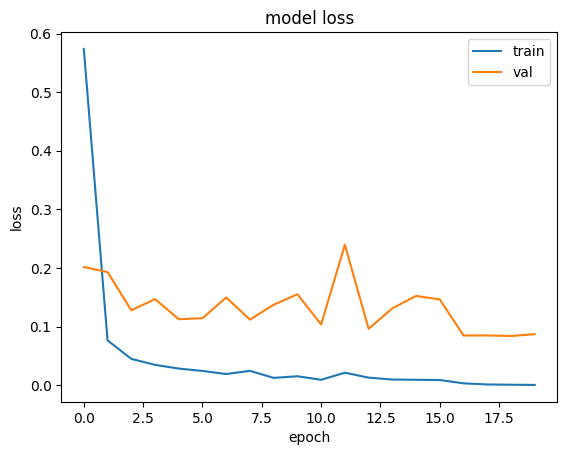

In [ ]:
show_history(historyV2)

In [ ]:
modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(trainset, verbose=2)
print(evalV2)

valV2 = modelV2.evaluate(testset, verbose=2)
print(valV2)

613/613 - 24s - loss: 4.6489e-05 - accuracy: 1.0000 - 24s/epoch - 40ms/step
[4.6489138185279444e-05, 1.0]
198/198 - 5s - loss: 0.0840 - accuracy: 0.9865 - 5s/epoch - 23ms/step
[0.08395793288946152, 0.98646080493927]


#### Definição do 3º modelo (Conv layers com mais filtros)

Ao aumentar o número de filtros em cada camada convolucional, a rede é capaz de aprender e extrair características mais complexas e abstratas das imagens de *input*. Cada filtro uma camada convolucional é responsável por detetar um conjunto específico de características de uma imagem, como bordas, texturas, padrões, entre outros. Quanto mais filtros uma camada tiver, mais características diferentes ela será capaz de capturar.

Na prática, uma abordagem comum é aumentar gradualmente o número de filtros à medida que a rede se aprofunda. Isso permite que as camadas iniciais aprendam características mais simples e gerais, enquanto as camadas mais profundas aprendem características mais específicas e complexas. Essa progressão gradual de filtros pode ajudar a melhorar a capacidade da rede de representar e distinguir características detalhadas nas imagens.

No nosso `model_III`, onde a última camada de convolução possui 256 filtros e a anterior possui 128 filtros, espera-se que a camada com mais filtros seja capaz de aprender características mais complexas e detalhadas do que a camada anterior; tal pode ser benéfico para a tarefa específica em questão, pois permite que a rede capture mais informações discriminativas das imagens durante o processo de aprendizagem.

Sendo assim, para o terceiro e último modelo tem-se:
1. **Aumento do número de filtros convolucionais**: O modelo III possui um número maior de filtros convolucionais em comparação ao modelo II, no âmbito de ajudar o modelo a capturar mais características relevantes nas imagens e extrair representações mais ricas dos dados.

2. **Diminuir o kernel das camadas convolucionais**: Diminuiu-se para ser (3,3), o que implica uma redução da área local da imagem que é levada em consideração durante a convolução.
  1. **Menor dimensionalidade**: Ao usar um *kernel* menor, a dimensão da saída da camada convolucional também será reduzida; útil quando se deseja reduzir a dimensionalidade espacial da imagem, como em camadas de pooling.
  2. **Maior foco local**: Com um *kernel* menor, a camada convolucional se concentra numa área menor da imagem de *input* o que pode permitir que a rede neural aprenda características mais localizadas e específicas, capturando detalhes finos ou padrões mais subtis.
  3. **Menor quantidade de parâmetros**: Reduzir o tamanho do *kernel* numa camada convolucional também resulta numa redução no número de parâmetros treináveis na rede neural, o que vai ser benéfico em termos de eficiência computacional e capacidade de generalização, especialmente em conjuntos de dados menores.

De resto, consegue-se ver que o modelo assemelha-se nos restantes aspetos ao modelo II.

In [ ]:
def model_III(classCount, imgSize, channels):

    model = Sequential()

    model.add(Conv2D(128, (3,3),
                     input_shape=(imgSize, imgSize, channels)
                     ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128, (3,3) ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3,3) ) )
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))


    opt = Adam(learning_rate=0.001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
modelV3 = model_III(43, 32, 3)

print(modelV3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 128)      

#### Resultados do fitting do modelo

Em termos das métricas a serem avaliadas, estas são tão boas ou melhores ao do modelo II, se considerarmos os resultados finais, contudo, se analisarmos no todo, temos que os valores são muito mais favoráveis e representam um modelo que está claramente a aprender; e que demonstra varições saudáveis para o *loss* e a *accuracy*.

Não obstante isso, o modelo também tem uma performance semelhante ao modelo II,
se avaliarmos o tempo para cada *epoch*, apesar de ser uma rede mais complexa;
para além disso, obteve-se um *early stopping* na *epoch* 18, o que significa que 20 *epochs* parece ser satisfatório para o modelo aprender corretamente
(segundo o que foi definido na função de *callbacks*).


In [ ]:
file_pathV3, callbacksM3 = prepareCallbacks('bestM3')

historyV3 = modelV3.fit(trainset,
                        epochs=20,
                        validation_data = testset,
                        callbacks=callbacksM3)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 1.7443 - accuracy: 0.5084
Epoch 1: val_loss improved from inf to 0.55113, saving model to dl04//bestM3/cp.ckpt
613/613 [==============================] - 39s 58ms/step - loss: 1.7443 - accuracy: 0.5084 - val_loss: 0.5511 - val_accuracy: 0.8352 - lr: 0.0010
Epoch 2/20
612/613 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.9015
Epoch 2: val_loss improved from 0.55113 to 0.21269, saving model to dl04//bestM3/cp.ckpt
613/613 [==============================] - 34s 55ms/step - loss: 0.3102 - accuracy: 0.9016 - val_loss: 0.2127 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9532
Epoch 3: val_loss improved from 0.21269 to 0.12975, saving model to dl04//bestM3/cp.ckpt
613/613 [==============================] - 34s 55ms/step - loss: 0.1515 - accuracy: 0.9532 - val_loss: 0.1298 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 4/20


#### Curvas de *loss* e *accuracy*

Aqui repara-se as maiores diferenças com os modelos anteriores, uma vez que as variações das curvas no modelo III representa algo próximo de um bom *fit*.

Continua a não ser perfeito, uma vez que as linhas tem uma clara distância entre elas mas, não obstante, não existem picos a significar overfitting/underfitting, ou que o modelo não teve dados representativos.

É claro que, com *data augmentation*, se pretende melhor os resultados finais.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


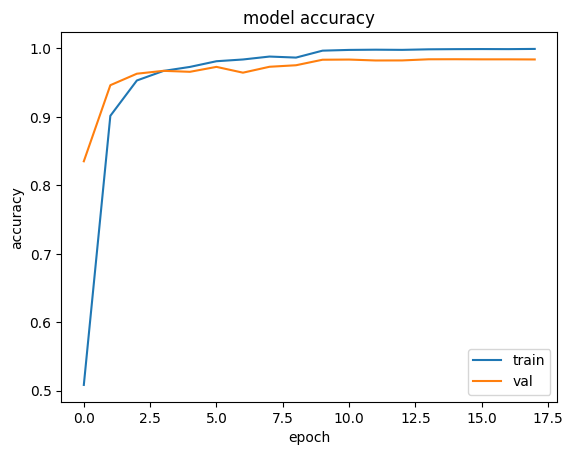

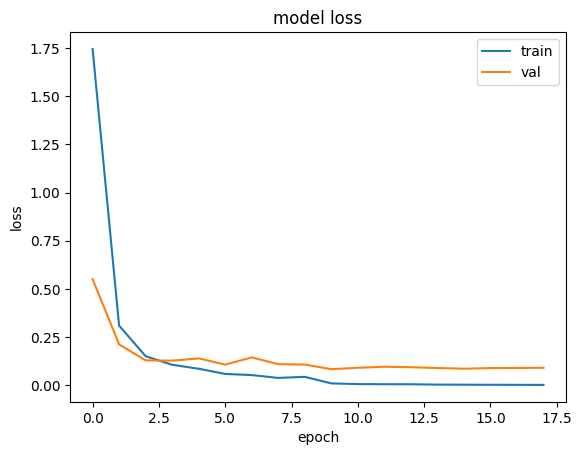

In [ ]:
show_history(historyV3)

In [ ]:
modelV3.load_weights(file_pathV3)

evalV3 = modelV3.evaluate(trainset, verbose=2)
print(evalV3)

valV3 = modelV3.evaluate(testset, verbose=2)
print(valV3)

613/613 - 22s - loss: 8.4276e-04 - accuracy: 0.9999 - 22s/epoch - 37ms/step
[0.0008427636348642409, 0.9998979568481445]
198/198 - 4s - loss: 0.0842 - accuracy: 0.9835 - 4s/epoch - 18ms/step
[0.0842135027050972, 0.9835312962532043]


### Comparação entre o modelo I e o modelo II

Por razões demosntrativas, apresenta-se um *side by side* dos dois primeiros
modelos (I e II).

Pelo que se repara na melhoria das métricas entre os modelos.

[0.9873243570327759, 1.0]


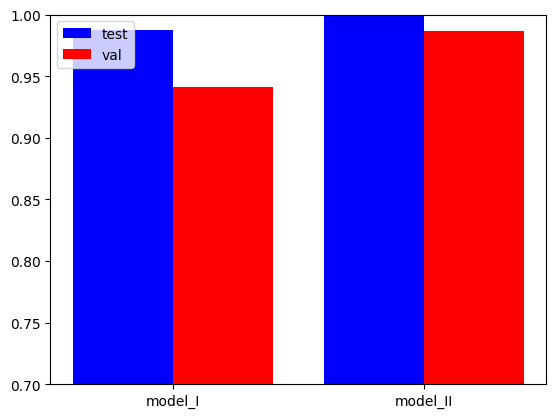

In [ ]:
test_averages = [evalV1[1], evalV2[1]]
val_averages = [valV1[1], valV2[1]]

print(test_averages)
show_data(test_averages,'test', val_averages,'val', ['model_I', 'model_II'])

### Comparação entre o modelo II e o modelo III

Testando o II modelo com o III atinge-se uma incógnita - ambos tem valores equitativos, neste caso, o II até possuí melhores resultados que o III.

Contudo, este gráfico apenas simboliza os valores de *accuracy* e *loss* finais e não são simbólicos da correção dos modelos em sí; nem representam uma boa métrica de comparação.

[1.0, 0.9998979568481445]


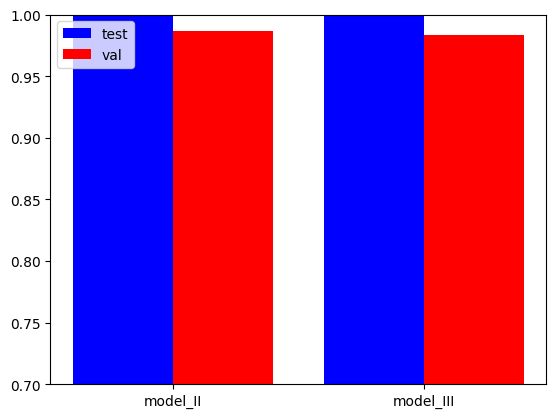

In [ ]:
test_averages = [evalV2[1], evalV3[1]]
val_averages = [valV2[1], valV3[1]]

print(test_averages)
show_data(test_averages,'test', val_averages,'val', ['model_II', 'model_III'])

## Data Augmentation

Para este caso, a nossa estratégia irá partir de testar, com o melhor modelo (III), várias das transformações fornecidas pelo *Keras*, sobre a classe `ImageDataGenerator` e descobrir quais são as mais satisfatórias; e que melhoram o nosso modelo.

Realiza-se o processo sobre o modelo III primeiro dado a ser o que possui melhores resultados, contudo, iremos. também, aplicar nos restantes dois modelos o mesmo processo de transformações, para visualizar as melhorias dadas;
e visualizar se diferentes transformações são melhores num modelo relativamente a outro.

### Transformações

As transformações que iremos testar nos nossos modelos serão as seguintes:

1. Rotação;
2. Zoom;
3. Translação;
4. Espelhamento;
5. Alteração de brilho e contraste;
6. Adição de ruído.

Como mencionado em cima, isto será aplicado através da classe `ImageDataGenerator`, no modelo III (posteriormente todos serão aplicados no outros).

A normalização, como já explicitado em cima, encontrará-se presente em todos
os geradores.

As comparações serão a partir dos resultados óbtidos sem qualquer *data augmentation*, sendo que nestes:
1. *accuracy* : *0.9993*;
2. *loss* : *0.0026*;
3. *val_accuracy*: *0.9839*;
4. *val_loss*: *0.0914*.

**Tentativa Rotação**

Considerando as *batches* visualizadas em cima, parece que as imagens geralmente têm a mesma orientção, pelo que o *range* da rotação escolhido foi
razoavelmente pequeno.

Neste sentido, o *range* máxima escolhido, em graus, foi de **20**.

In [ ]:
# Gerador (Rotação)
datagen_rot = ImageDataGenerator(
    rotation_range=20,   # Ângulo máximo de rotação (em graus)
    rescale=1./255
)

trainset = datagen_rot.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


In [ ]:
file_path_rot, callbacks_rot = prepareCallbacks('V3_rot')

history_rot = modelV3.fit(trainset,
                          epochs=20,
                          validation_data = testset,
                          callbacks=callbacks_rot)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 1.5716 - accuracy: 0.5573
Epoch 1: val_loss improved from inf to 0.36508, saving model to dl04//V3_rot/cp.ckpt
613/613 [==============================] - 66s 86ms/step - loss: 1.5716 - accuracy: 0.5573 - val_loss: 0.3651 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8856
Epoch 2: val_loss improved from 0.36508 to 0.18311, saving model to dl04//V3_rot/cp.ckpt
613/613 [==============================] - 51s 84ms/step - loss: 0.3609 - accuracy: 0.8856 - val_loss: 0.1831 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9303
Epoch 3: val_loss did not improve from 0.18311
613/613 [==============================] - 56s 91ms/step - loss: 0.2235 - accuracy: 0.9303 - val_loss: 0.2157 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 4/20
613/613 [==============================] -

#### *History* do *fit*

Comparando os resultados do *fitting* com as óbtidas anteriormente, temos que:

- Os valores relativos ao *dataset* de treino (*accuracy* e *loss*) encontram-se um pouco a baixo dos óbtidos no *fitting* inicial; mas a diferença é insignificante, pelo que continuam muito bons.
- Por outro lado, os valores relativos ao *dataset* de teste obtiveram melhorias, tanto na *val_accuracy*, como na *val_loss*; agora são, respetivamente, **98.65%** e **0.0702**.

Contudo, é também necessário sublinhar que a performance, no geral, diminui,
pelo que o tempo por *epoch* passou a ser, em média, **50 segundos**.
Estes valores provavelmente conseguiriam usufruir de mais *epochs*, considerando que não houve nenhum *early stopping* e, próximo do fim, ainda haviam melhorias no *loss* do *dataset* de validação.

Não obstante, consiste numa operação que pode ser usado no final, em termos de teste.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


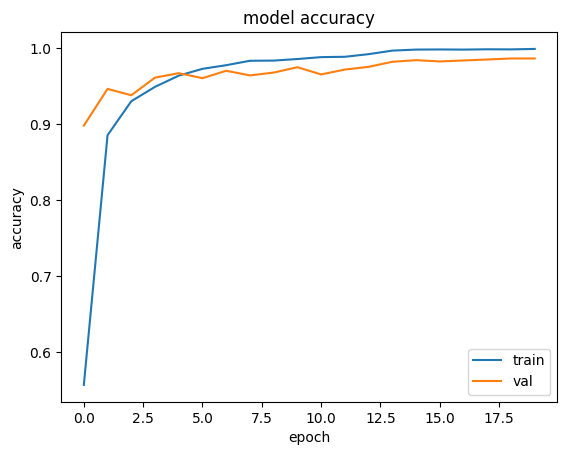

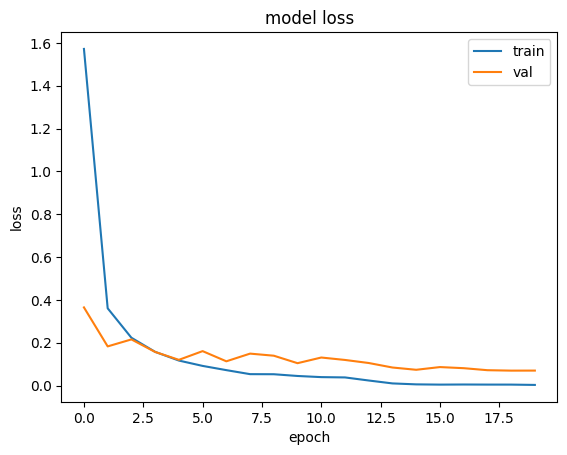

In [ ]:
show_history(history_rot)

**Tentativa Zoom**

Neste caso, podemos definir, tal como na rotação, um *range* para os níveis de *zoom* que se pode efetuar nas imagens.
O valor dado foi de **0.2**; o que implica que as imagens podem ser *zoomed in or out* por um fator até *20%*.

Deste moso, consegue-se pequenas variações na escala dos objetos nas imagens, de modo a generalizar e lidar com variações de um modo mais eficiente.

Escolheu-se o valor *0.2* por ser um *default* razoável em *data augmentation*, de modo a introduzir variação suficiente sem distorcer demasiado os objetos nas imagens ao ponto de serem irreconheciveis.

In [ ]:
# Gerador (Zoom)

datagen_zoom = ImageDataGenerator(
    zoom_range=0.2,     # Faixa de zoom in/out
    rescale=1./255
)

trainset = datagen_zoom.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


In [ ]:
file_path_zoom, callbacks_zoom = prepareCallbacks('V3_zoom')

history_zoom = modelV3.fit(trainset,
                           epochs=20,
                           validation_data = testset,
                           callbacks=callbacks_zoom)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9971
Epoch 1: val_loss improved from inf to 0.08963, saving model to dl04//V3_zoom/cp.ckpt
613/613 [==============================] - 67s 109ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0896 - val_accuracy: 0.9835 - lr: 2.0000e-04
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9980
Epoch 2: val_loss improved from 0.08963 to 0.06522, saving model to dl04//V3_zoom/cp.ckpt
613/613 [==============================] - 48s 78ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0652 - val_accuracy: 0.9867 - lr: 2.0000e-04
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9986
Epoch 3: val_loss did not improve from 0.06522
613/613 [==============================] - 47s 77ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0759 - val_accuracy: 0.9852 - lr: 2.0000e-04
Epoch 4/20
613/613 [==================

### Resultados do *fitting*

No que toca ao *zoom*, pode-se verificar que ocorre algo semelhante às rotações, na medida em que os valores finais óbtidos tem claras melhorias relativamente ao modelo sem *data augmentation*, no que toca aos valores das métricas do *dataset* de validação.

O *val_accuracy* e *val_loss* tem valores muito satisfatórios e são um avança;
*98.89%* e *0.0606*, respetivamente.

A *performance* é outro aspeto que se assemelha à rotação, existindo um aumento de tempo, para **50 segundos**, em média.
Contudo, no *zoom* ocorre um *early stopping*, que é visível nas curvas a baixo,
para *accuracy* e *loss*, que não são as mais presentáveis; sendo que isto é devido ao facto do modelo não ter tido muito treino.

Não obstante isto, o *zoom* apresenta-se como uma transformação a adicionar no modelo final.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


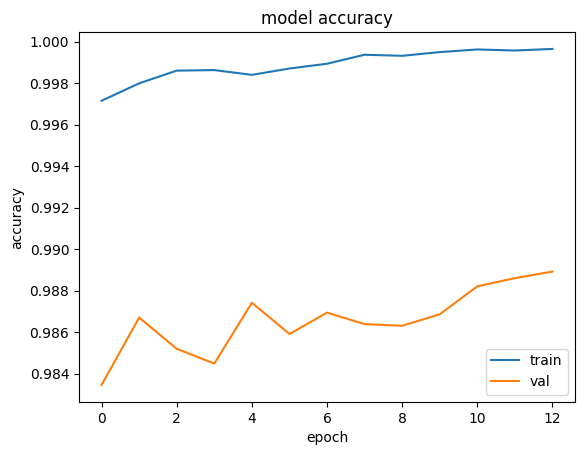

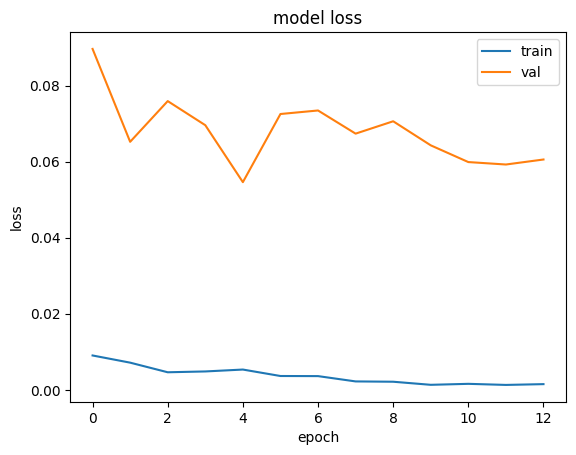

In [ ]:
show_history(history_zoom)

**Tentativa Translação**

A translação é uma transformação que desloca a imagem horizontalmente e verticalmente, criando variações na posição dos objetos presentes na imagem.
Análogo a exemplos anteriores, o valor de **0.2** é uma escolha comum que geralmente proporciona um equilíbrio razoável entre introduzir variações na posição dos objetos e preservar a semântica e as características essenciais das imagens.

Neste caso, define-se, isoladamente, o *range* para a altura e a largura;
*width_shift_range* e *height_shift_range*, repetivamente.


In [ ]:
# Gerador (Translação)

datagen_trans = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255
)

trainset = datagen_trans.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


In [ ]:
file_path_trans, callbacks_trans = prepareCallbacks('V3_trans')

history_trans = modelV3.fit(trainset,
                           epochs=20,
                           validation_data = testset,
                           callbacks=callbacks_trans)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 3.5430 - accuracy: 0.4151
Epoch 1: val_loss improved from inf to 0.14723, saving model to dl04//V3_trans/cp.ckpt
613/613 [==============================] - 58s 95ms/step - loss: 3.5430 - accuracy: 0.4151 - val_loss: 0.1472 - val_accuracy: 0.9563 - lr: 1.0000e-05
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 2.3290 - accuracy: 0.4219
Epoch 2: val_loss did not improve from 0.14723
613/613 [==============================] - 63s 103ms/step - loss: 2.3290 - accuracy: 0.4219 - val_loss: 0.1529 - val_accuracy: 0.9577 - lr: 1.0000e-05
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 2.0798 - accuracy: 0.4582
Epoch 3: val_loss improved from 0.14723 to 0.14110, saving model to dl04//V3_trans/cp.ckpt
613/613 [==============================] - 54s 88ms/step - loss: 2.0798 - accuracy: 0.4582 - val_loss: 0.1411 - val_accuracy: 0.9608 - lr: 1.0000e-05
Epoch 4/20
613/613 [================

Encontra-se com a translação o primeiro exemplo de uma transformação com a qual o modelo não conseguiu corretamente lidar.

Neste caso, ignorando o peso na *performance* que todas as transformações têm tido, temos que, com as translações, os valores para todas as métricas (treino e validação) tiveram valores piores; especialmente o de treino.
Isto implica que o modelo não conseguiu identificar o próprio *dataset* utilizado para treino.

Consequentemente, visualiza-se nas respetivas curvas de *accuracy* e *loss* que não existiu convergência; sendo que a culpa não se encontrou no *early stopping* como em exemplos anteriores.
Secalhar com mais *epochs* os resultados compensam, contudo, a penalização na performance seria demasiado elevada.

Por este motivo, as translações serão uma transformação a ignorar.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


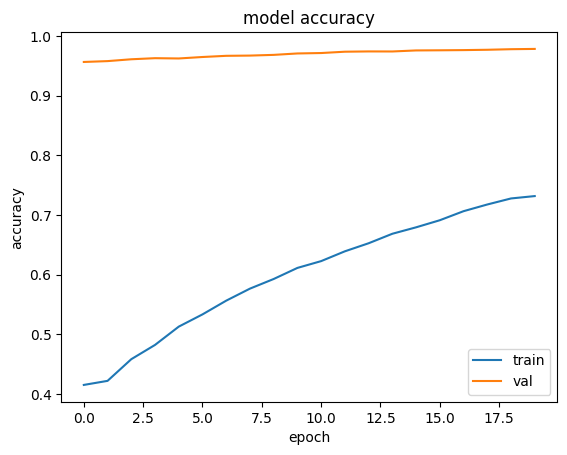

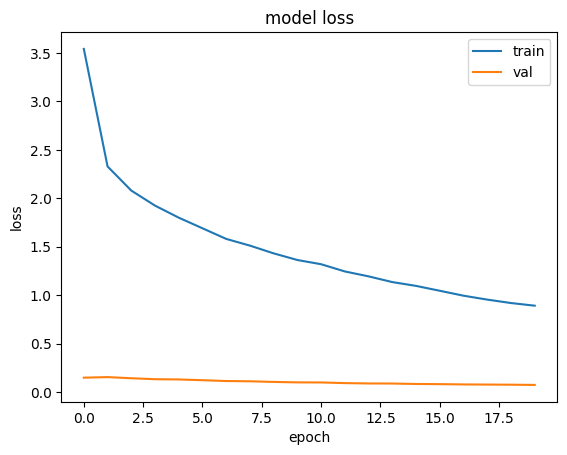

In [ ]:
show_history(history_trans)

**Tentativa Espelhamento**

A transformação "*horizontal_flip*" é uma técnica de *data augmentation* que consiste em espelhar horizontalmente as imagens durante o treino; pelo que as imagens podem ser invertidas em relação ao eixo vertical, como se fossem vistas num espelho.

A utilização do "horizontal_flip" ajuda a tornar o modelo mais robusto a variações na orientação dos objetos, tal como exemplos anteriores, melhorando a capacidade de generalização do modelo para dados de teste que podem conter objetos em diferentes orientações.

Neste caso, só recebe um valor *booleano*, que será **True**.

In [ ]:
# Gerador (Espelhamento)

datagen_flip = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255
)

trainset = datagen_flip.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


In [ ]:
file_path_flip, callbacks_flip = prepareCallbacks('V3_flip')

history_flip = modelV3.fit(trainset,
                           epochs=20,
                           validation_data = testset,
                           callbacks=callbacks_flip)

Epoch 1/20
612/613 [============================>.] - ETA: 0s - loss: 0.9096 - accuracy: 0.7928
Epoch 1: val_loss improved from inf to 0.16670, saving model to dl04//V3_flip/cp.ckpt
613/613 [==============================] - 27s 44ms/step - loss: 0.9094 - accuracy: 0.7928 - val_loss: 0.1667 - val_accuracy: 0.9504 - lr: 1.0000e-05
Epoch 2/20
612/613 [============================>.] - ETA: 0s - loss: 0.5837 - accuracy: 0.8350
Epoch 2: val_loss improved from 0.16670 to 0.14939, saving model to dl04//V3_flip/cp.ckpt
613/613 [==============================] - 30s 48ms/step - loss: 0.5839 - accuracy: 0.8351 - val_loss: 0.1494 - val_accuracy: 0.9577 - lr: 1.0000e-05
Epoch 3/20
612/613 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.8610
Epoch 3: val_loss improved from 0.14939 to 0.13715, saving model to dl04//V3_flip/cp.ckpt
613/613 [==============================] - 31s 50ms/step - loss: 0.4736 - accuracy: 0.8610 - val_loss: 0.1372 - val_accuracy: 0.9625 - lr: 1.0000e

### Resultados *fitting*

Num caso menos extremo que o das translações, o **espelhamento** também apresenta, em todos os aspetos, resultados piores aos óbitos inicialmente pelo modelo (sem *data augmentation*).

Contudo, neste caso, pelo menos as curvas de *accuracy* e *loss* convergem num ponto entre os *datasets* de teste e treino, o que é uma melhoria dos resultados, quase análogos a um caso de *underfitting*, das translações.

Concluindo, a *data augmentation*, com o espelhamento teve valores, para as métricas de validação, como:
- *val_accuracy* : **97.15%**;
- *val_loss* : **0.1031**.

Para as de treino:
- *accuracy* : **97.38%**;
- *loss* : **0.0788**;

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


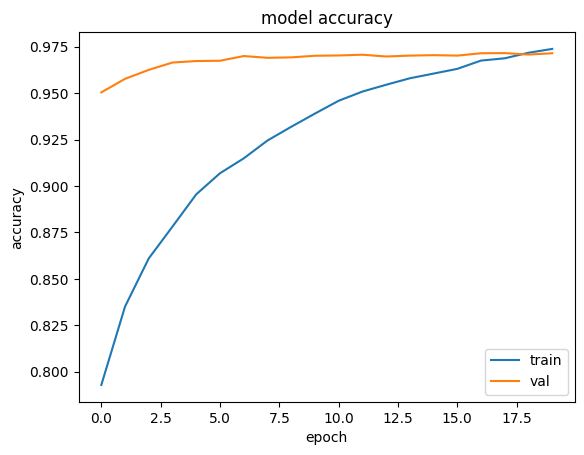

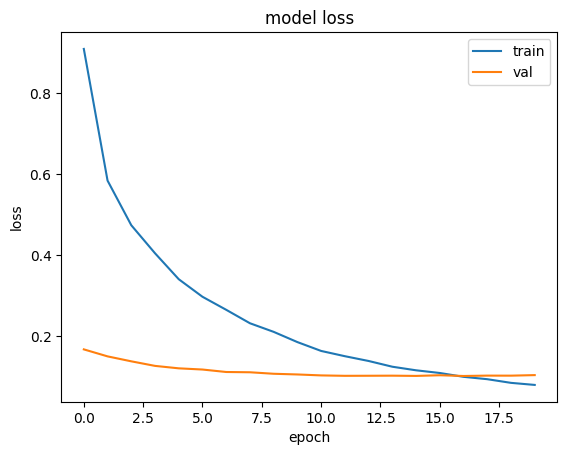

In [ ]:
show_history(history_flip)

**Tentativa alteração do brilho**

O *"brightness_range"* é uma técnica de *data augmentation* que ajusta o brilho das imagens durante o treino, permitindo aumentar ou diminuir o brilho das imagens; e adicionar variações ao conjunto de dados.

O parâmetro *"brightness_range"* é uma tuplo que define a faixa de variação de brilho que será aplicada às imagens. Por exemplo, se for definido tal como *"brightness_range=(0.5, 1.5)"*; significa que o brilho das imagens pode variar entre 50% e 150% do brilho original.

Neste caso, tal como os exemplos anterirores foi-se com uns valores *default*, genéricos, para testar se o modelo teria ou não aversão a estas transformações.

Para simular variações de brilho que ocorram naturalmente nas imagens é importante escolher uma faixa de valores que seja realista. Observando o intervalo de brilho presente nas imagens do nosso *dataset*, tem-se que serão necessárias mundanças de contraste mais subtis; daí o *range* permancer pequeno.

In [ ]:
# Gerador (brilho)

datagen_bright = ImageDataGenerator(
    brightness_range=[0.5, 1.5],
    rescale=1./255
)

trainset = datagen_bright.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


In [ ]:
file_path_bright, callbacks_bright = prepareCallbacks('V3_bright')

history_bright = modelV3.fit(trainset,
                           epochs=20,
                           validation_data = testset,
                           callbacks=callbacks_bright)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9939
Epoch 1: val_loss improved from inf to 0.08250, saving model to dl04//V3_bright/cp.ckpt
613/613 [==============================] - 39s 63ms/step - loss: 0.0220 - accuracy: 0.9939 - val_loss: 0.0825 - val_accuracy: 0.9774 - lr: 1.0000e-05
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9961
Epoch 2: val_loss improved from 0.08250 to 0.07225, saving model to dl04//V3_bright/cp.ckpt
613/613 [==============================] - 39s 63ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.0723 - val_accuracy: 0.9811 - lr: 1.0000e-05
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9981
Epoch 3: val_loss improved from 0.07225 to 0.06586, saving model to dl04//V3_bright/cp.ckpt
613/613 [==============================] - 39s 63ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0659 - val_accuracy: 0.9823 - lr: 1

### Resultados *fitting*

Neste caso, tal como nas rotações e nmo *zoom*, encontram-se melhorias aqui, com as alterações do contraste das imagens.

Mais uma vez, tems-se:
- Métricas do *dataset* de treino: Permanecem-se equivalentes, ou até melhores, do que as do *fit* inicial, o que indica que consegue quase perfeitamente identificar as imagens do *dataset* de treino.
- Métricas do *dataset* de teste: Existem melhorias aqui, de certo modo significativas. Os valores para *val_accuracy* e *loss* encontram-se agora, respetivamente, como *98,99%* e *0.0416*.

Adicionalmente, como uma exceção à regra, as alterações no brilho das imagens dos *datasets* não só trouxe uma melhoria clara na aprendizagem do modelo, como possui uma melhor *performance* comparada com os restantes exemplos; em média, **41 segundos** por *epoch* (próximo da realidade sem *data augmentation*).

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


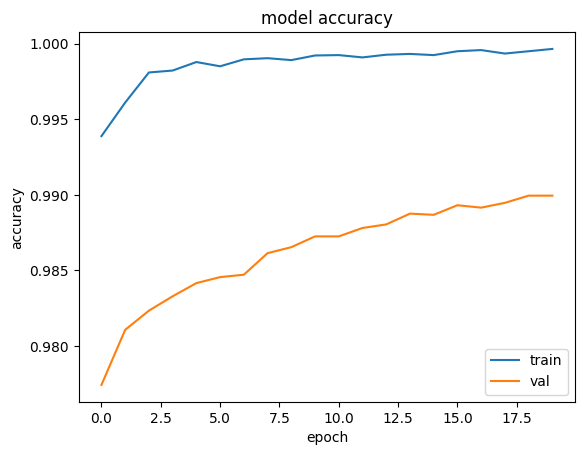

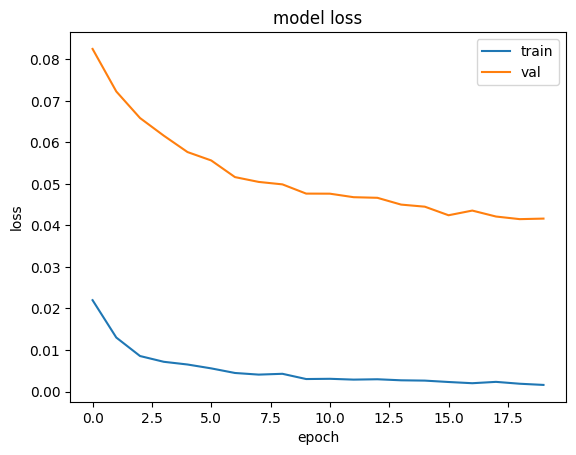

In [ ]:
show_history(history_bright)

**Tentativa adição de ruído**

A adição de ruído como técnica de *data augmentation* envolve a introdução de ruído aleatório nas imagens durante o treino, com o objetivo de tornar o modelo mais robusto a variações e imperfeições presentes nos dados reais.

A adição de ruído pode ajudar a melhorar a capacidade do modelo de generalizar (como nota-se no geral com todas as transformações), especialmente em situações em que as imagens de treino não capturam todas as variações e perturbações presentes nos dados do mundo real. Ao introduzir ruído nas imagens, o modelo é exposto a diferentes padrões e variações, o que pode ajudar a evitar o *overfitting* e melhorar a sua capacidade de lidar com dados reais.

Alguns tipos comuns de ruído incluem o **ruído gaussiano**, **ruído com sal e pimenta**, **ruído speckle**, entre outros.

ara o exemplo atual, utilizou-se **ruído gaussiano**, uma vez que traz uma natureza realista, controla a intensidade e é bastante robusto.

In [ ]:
# Gerador (ruído)

## Método para adicionar ruído
def add_noise(image):
    noise = np.random.normal(loc=0, scale=25, size=image.shape)  # Geração de ruído aleatório
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)  # Adição do ruído à imagem original
    return noisy_image

datagen_noise = ImageDataGenerator(
    preprocessing_function=add_noise  # Função para adicionar ruído
)

trainset = datagen_noise.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


In [ ]:
file_path_noise, callbacks_noise = prepareCallbacks('V3_noise')

history_noise = modelV3.fit(trainset,
                           epochs=20,
                           validation_data = testset,
                           callbacks=callbacks_noise)

Epoch 1/20
612/613 [============================>.] - ETA: 0s - loss: 0.3149 - accuracy: 0.9184
Epoch 1: val_loss improved from inf to 12.33206, saving model to dl04//V3_noise/cp.ckpt
613/613 [==============================] - 38s 62ms/step - loss: 0.3146 - accuracy: 0.9185 - val_loss: 12.3321 - val_accuracy: 0.0285 - lr: 1.0000e-05
Epoch 2/20
612/613 [============================>.] - ETA: 0s - loss: 0.2600 - accuracy: 0.9282
Epoch 2: val_loss improved from 12.33206 to 10.67605, saving model to dl04//V3_noise/cp.ckpt
613/613 [==============================] - 37s 60ms/step - loss: 0.2602 - accuracy: 0.9281 - val_loss: 10.6760 - val_accuracy: 0.0694 - lr: 1.0000e-05
Epoch 3/20
612/613 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9329
Epoch 3: val_loss did not improve from 10.67605
613/613 [==============================] - 38s 62ms/step - loss: 0.2378 - accuracy: 0.9329 - val_loss: 10.7294 - val_accuracy: 0.0523 - lr: 1.0000e-05
Epoch 4/20
613/613 [==========

### Resultados do *fitting*

Por fim, juntando-se às translações, o ruído adicionado trouxe resultados muito a baixo da média desejada; comparável ou melhor do que o *fit* inicial do modelo.

Em todos os aspetos, menos *performance*, esta transformação é pior que as anteriores, visualizado, também, nas curvas de *accuracy* e *loss*.
Estas apresentam um modelo que, em boa prática, necessitaria provavlemente de mais *epochs* para aprender com maior correção.
Contudo, apesar de a *performance* ser melhor que os restantes, continua, comparativamente com o orginal, a ser pior nos tempos óbtidos; pelo que usar mais *epochs* implica um descréscimo relativamente alto da performance para este modelo.

Adicionalmente, num ponto de vista crítico, parece que os resultados não se vão materializar; em boa prática, outros tipos de ruído devem ser também testados.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


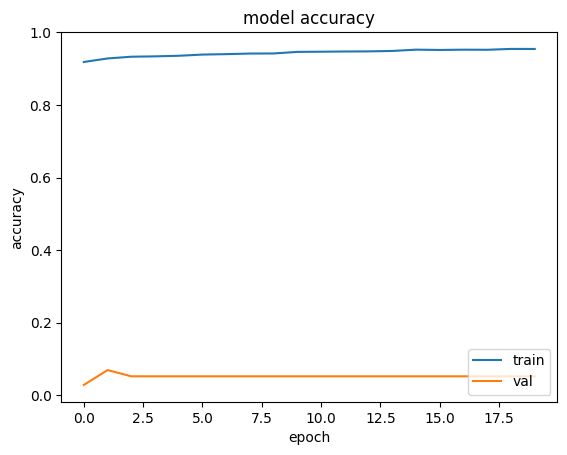

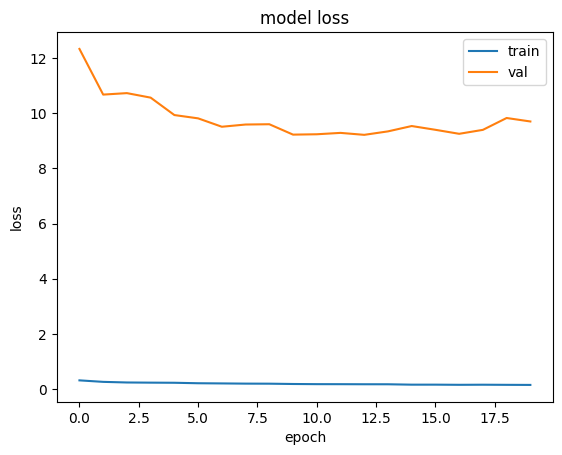

In [ ]:
show_history(history_noise)

### Resultados

A partir de todas as transformações anteriormente enumeradas, desde as rotações à adição de ruído, apenas três trouxeram resultados considerados melhores do que o óbtido unicamente com a normalização; para o modelo III definido em cima (como sendo o melhor).
Estas foram:
1. **Rotação**;
2. **Zoom**;
3. **Alteração de brilho**.

As novas alterações, implementadas com *data augmentation* trouxeram, respetivamente:
- *accuracy* - 0.9991, 0.9996, 0.9996;
- *loss* - 0.0033, 0.0015 0.0016;
- *val_accuracy* - 0.9865, 0.9889, 0.9899;
- *val_loss* - 0.0702, 0.0606, 0.0416.

Considerando os valores iniciais, temos que existe nos melhores dos casos, melhorias de:
- *accuracy* ≈ +**0.0003**.
- *loss* ≈ -**0.0010**.
- *val_accuracy* ≈ +**0.0060**.
- *val_loss* ≈ -**0.05**.


Sendo assim, irá-se utilizar, no final estas três transformações, para o modelo III, de modo a aumentar, com *data augmentation*, os valores das métricas desejados.

### Utilização de todas as transformações (em conjunto)

Para a tentativa final, com todas as transformações, utilizou-se os mesmos valores para construir o gerador de
dados.

In [ ]:
# Gerador com todas as transformações aplicadas

datagen_final = ImageDataGenerator(
    rotation_range=20,              # Ângulo máximo de rotação (em graus)
    zoom_range=0.2,                 # Faixa de zoom in/out
    brightness_range=[0.5, 1.5],    # Range para o brilho
    rescale=1./255
)

trainset = datagen_final.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


In [ ]:
file_path_III, callbacks_III = prepareCallbacks('V3_full')

history_III = modelV3.fit(trainset,
                        epochs=20,
                        validation_data = testset,
                        callbacks=callbacks_III)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9851
Epoch 1: val_loss improved from inf to 3.35928, saving model to dl04//V3_full/cp.ckpt
613/613 [==============================] - 65s 107ms/step - loss: 0.0487 - accuracy: 0.9851 - val_loss: 3.3593 - val_accuracy: 0.4269 - lr: 1.0000e-05
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9915
Epoch 2: val_loss improved from 3.35928 to 0.04487, saving model to dl04//V3_full/cp.ckpt
613/613 [==============================] - 68s 111ms/step - loss: 0.0293 - accuracy: 0.9915 - val_loss: 0.0449 - val_accuracy: 0.9880 - lr: 1.0000e-05
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9935
Epoch 3: val_loss improved from 0.04487 to 0.04197, saving model to dl04//V3_full/cp.ckpt
613/613 [==============================] - 67s 110ms/step - loss: 0.0217 - accuracy: 0.9935 - val_loss: 0.0420 - val_accuracy: 0.9894 - lr: 1.00

### Resultados do *fitting*

Neste caso, como esperado, houve melhorias significativas com a aplicação das três transformações. em simultâneo, sobre o modelo III.

Não obstante os valores finais, que são todos melhorias relativamente aos óbtidos em testes prévios (*accuracy* ≡ **99.71%**, *loss* ≡ **0.0096**, *val_accuracy* ≡ **99.10%** e *val_loss* ≡ **0.0408**), as curvas de aprendizagem óbtidas para as métricas de *accuracy* e *loss* demonstram que o modelo está a conseguir identificar as imagens de ambos os *datasets* quase perfeitamente.

Isto implica que haverá algum *overfitting*, dado que deve sempre haver algumas irregularidades e não linearidades, mas que, no contexto destes datasets, implicam muitos bons resultados.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


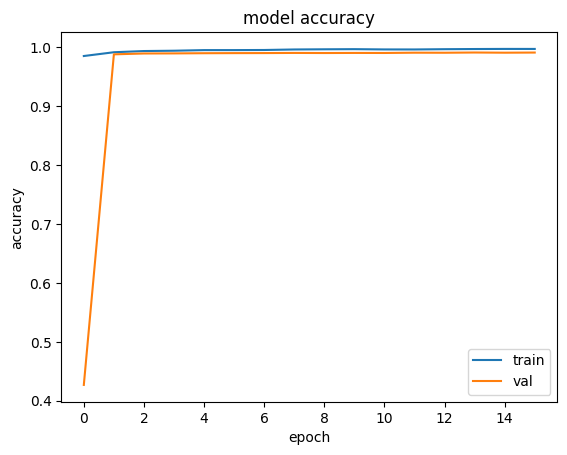

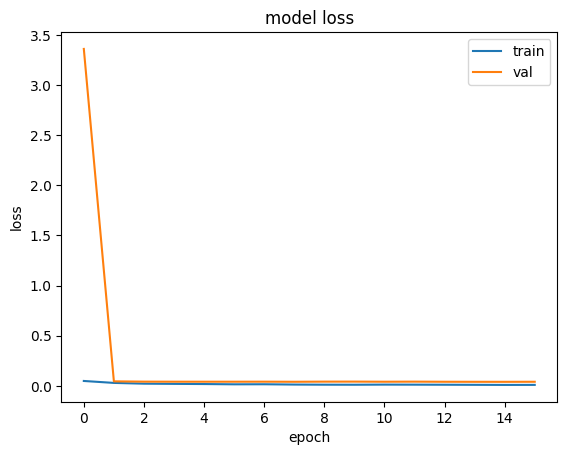

In [ ]:
show_history(history_III)

#### Data Augmentation nos modelos I e II

De modo a perceber o impacto das transformações, encontradas como sendo as melhores sobre o modelo III, nos modelos I e II, vão ser aplicadas em conjunto.
Os respetivos resultados serão analisados.

**Modelo I**

In [ ]:
file_path_I, callbacks_I = prepareCallbacks('V1_full')

history_I = modelV1.fit(trainset,
                        epochs=20,
                        validation_data = testset,
                        callbacks=callbacks_I)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 0.8359 - accuracy: 0.7670
Epoch 1: val_loss improved from inf to 0.30153, saving model to dl04//V1_full/cp.ckpt
613/613 [==============================] - 67s 104ms/step - loss: 0.8359 - accuracy: 0.7670 - val_loss: 0.3015 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9480
Epoch 2: val_loss improved from 0.30153 to 0.17994, saving model to dl04//V1_full/cp.ckpt
613/613 [==============================] - 62s 102ms/step - loss: 0.1799 - accuracy: 0.9480 - val_loss: 0.1799 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9669
Epoch 3: val_loss did not improve from 0.17994
613/613 [==============================] - 66s 107ms/step - loss: 0.1107 - accuracy: 0.9669 - val_loss: 0.1862 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 4/20
613/613 [============================

### Resultados do *fitting*

Apesar de não ter sido testado individualmente, com as respetivas transformações mencionadas anteriormente, consegue-se, puramente por observação das curvas de aprendizagem (tal como dos valores das métricas finais), que o conjunto de transformações que funcionaram para o modelo III, também têm efeitos positivos no modelo I.

Neste caso, o modelo apresenta melhores valores para as suas métricas como, por exemplo, a *accuracy* do *dataset* de teste, com um aumento significativo de ≈*1%*.

As curvas apresentam agora um *fit* mais saudável, se bem que continua com alguns picos acentuados, o que sinaliza um término demasiado rápido para a aprendizagemn (de facto, ocorreu um *early stopping*).

Contudo, valores muito satisfatórios para o modelo I, que era muito simples na sua construção e simplicidade; apesar que a sua performance foi atingida (duração do dobro do tempo).

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


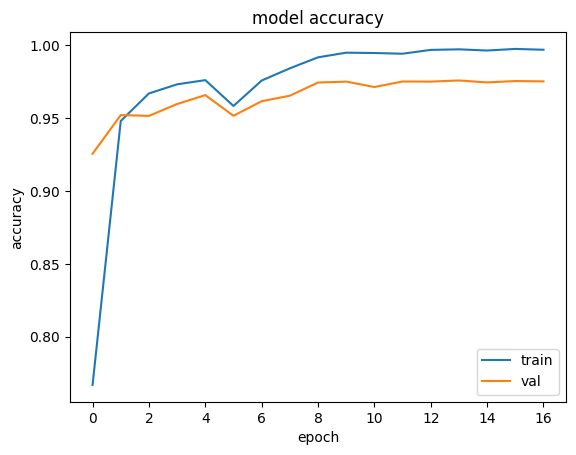

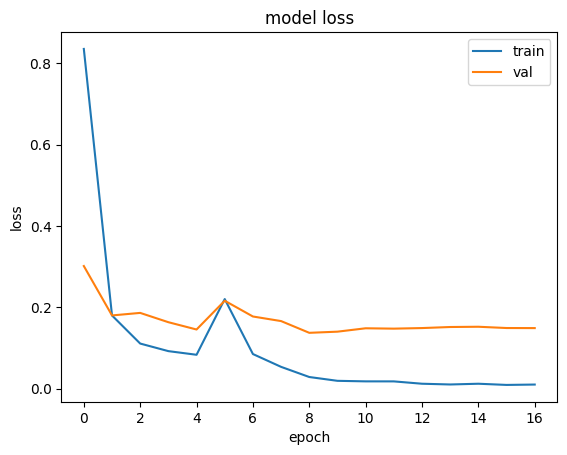

In [ ]:
show_history(history_I)

**Modelo II**

In [ ]:
file_path_II, callbacks_II = prepareCallbacks('V2_full')

history_II = modelV2.fit(trainset,
                        epochs=20,
                        validation_data = testset,
                        callbacks=callbacks_II)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.7631
Epoch 1: val_loss improved from inf to 0.19820, saving model to dl04//V2_full/cp.ckpt
613/613 [==============================] - 68s 105ms/step - loss: 0.8358 - accuracy: 0.7631 - val_loss: 0.1982 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9388
Epoch 2: val_loss improved from 0.19820 to 0.11217, saving model to dl04//V2_full/cp.ckpt
613/613 [==============================] - 63s 102ms/step - loss: 0.2013 - accuracy: 0.9388 - val_loss: 0.1122 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9566
Epoch 3: val_loss did not improve from 0.11217
613/613 [==============================] - 61s 100ms/step - loss: 0.1439 - accuracy: 0.9566 - val_loss: 0.1384 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 4/20
613/613 [============================

### Resultados do *fitting*

O modelo II, por outro lado, apesar de as métricas (no final), terem valores análogos ao seu treino anterior, ele apresenta curvas de *accuracy* e *loss* vastamente melhores; neste caso, de todos os modelos até então, deve ser o que apresenta o melhor *fit*.

Existe uma clara convergência entre a aprendizagem de ambos os *datasets*, sem haver claros sinais de *overfitting*.
Apear de existirem alguns picos "pouco suaves", é uma boa representação para o *dataset*; sendo que os valores finais, apesar de não serem os melhores entre os testados, são bons vistos de um ponto de vista isolado.

Adicionalmente, a performance está análoga aos anteriores, quando aplicada a *data augmentation*.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


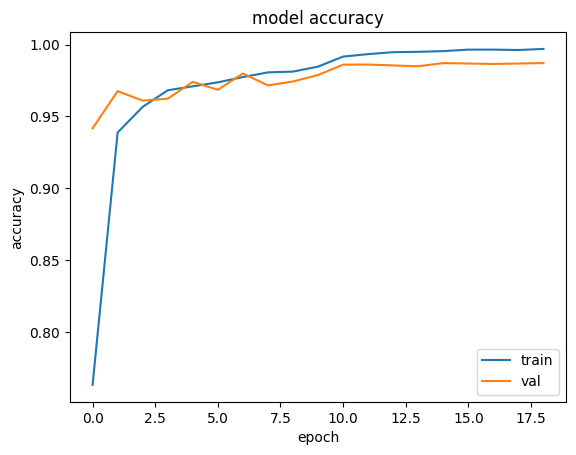

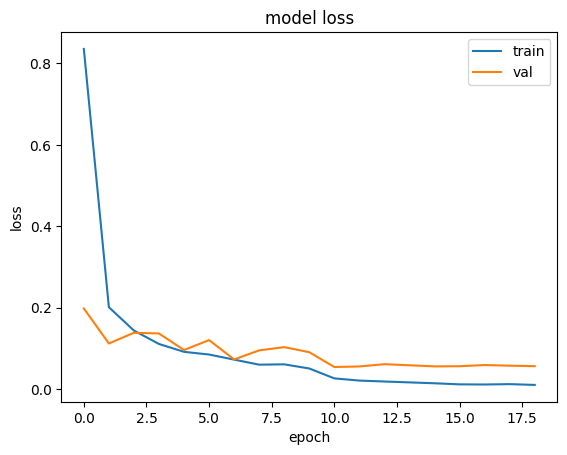

In [ ]:
show_history(history_II)

### Considerações finais sobre a *data augmentation*

Pode-se considerar que a implementação de *data augmentation* foi um sucesso que, no melhor dos casos, conseguiu trazer a *accuracy* do *dataset* de teste para
**99.11%**.

Neste sentido, conseguiu-se obter os resultados com as transformações:
1. **Rotação**;
2. **Zoom**;
3. **Alteração do brilho**.

## Essembles

In [61]:
## Número de models
NUM_MODELS = 3
file_path_prefix = f'{WEIGHT_FILE_PREFIX}V1'
TRAIN_ONLINE = True # if True it will train models, otherwise it will load weights

#### Preparação do dataset de treino (utilizando a data augmentation)

In [17]:
# Gerador com todas as transformações aplicadas

datagen_final = ImageDataGenerator(
    rotation_range=20,              # Ângulo máximo de rotação (em graus)
    zoom_range=0.2,                 # Faixa de zoom in/out
    brightness_range=[0.5, 1.5],    # Range para o brilho
    rescale=1./255
)

trainset = datagen_final.flow_from_directory(
    data_png_train,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)

Found 39209 images belonging to 43 classes.


#### Visualização das imagens após o processamento

Consegue-se visualizar as transformações realizadas, num *batch* aleatório.

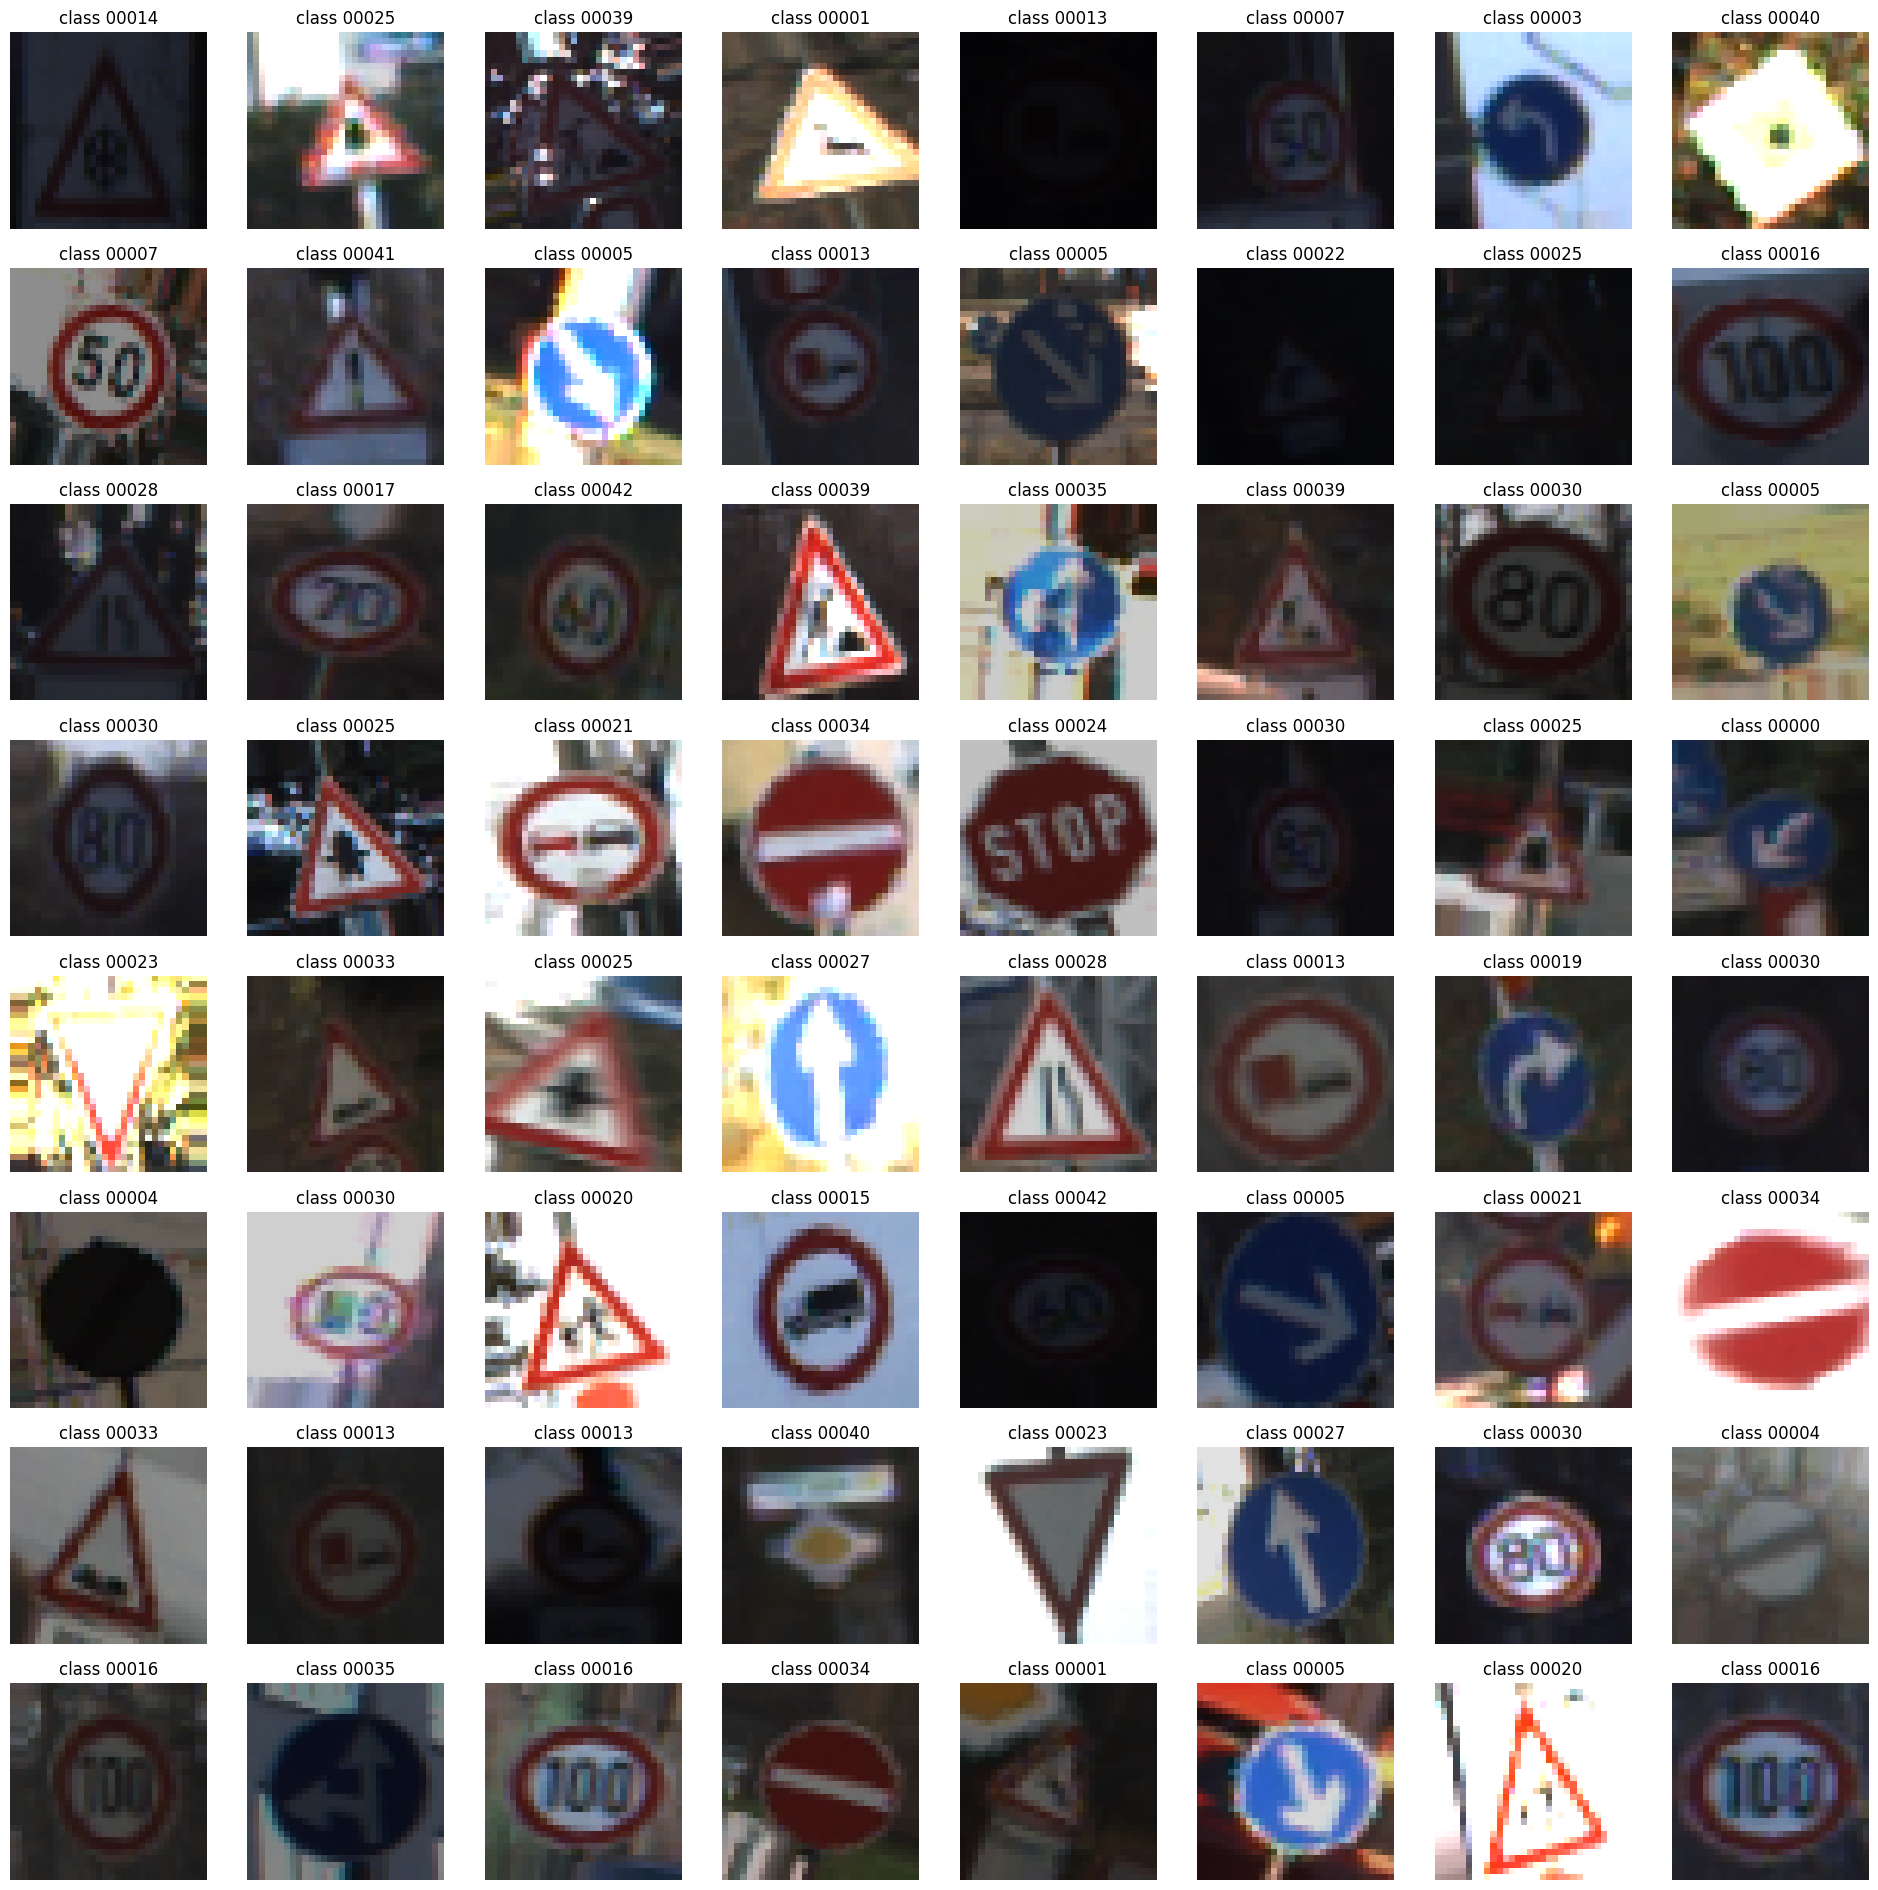

<Figure size 640x480 with 0 Axes>

In [18]:
image_batch, label_batch = next(iter(trainset))
show_batch(8,image_batch, label_batch)

### Outra função de Callbacks (neste caso, o tratamento dos paths é diferente)

Para testar com diferentes aspetos, utilizou-se métricas diferentes (e valores diferentes).

In [57]:
def prepare_callbacks_essemble(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path,
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

### Definição do modelo

Exatamente como o modelo III (apresentado previamente);
mas neste caso retorna dois objetos : o modelo completo e o modelo "base" sem a camada de *output*.
1. `model`: Este é o modelo completo, que inclui todas as camadas, desde a entrada até a camada de saída. Ele é criado usando a classe tf.keras.Model do TensorFlow. O modelo completo é usado para treino, avaliação e previsão.
2. `modelLogits` : Este é o modelo "base" sem a camada de saída. Ele contém todas as camadas até a camada anterior à camada de saída. É uma instância da classe `Sequential` do *Keras* e é usado para calcular os **logits** (valores de saída antes da aplicação da função de ativação softmax) das amostras de entrada. Esse modelo é útil para calcular os logits separadamente ou mesmo para realizar um ajuste fino em apenas uma parte do modelo.

In [28]:
def create_model(classCount, imgSize, channels):

    modelLogits = Sequential()

    modelLogits.add(Conv2D(128, (3,3),
                     input_shape=(imgSize, imgSize, channels)
                     ))
    modelLogits.add(BatchNormalization())
    modelLogits.add(LeakyReLU(alpha=0.01))

    modelLogits.add(Conv2D(128, (3, 3) ))
    modelLogits.add(BatchNormalization())
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))

    modelLogits.add(Conv2D(256, (3, 3) ) )
    modelLogits.add(BatchNormalization())
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))

    modelLogits.add(Flatten())
    modelLogits.add(Dense(128))
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(Dropout(0.2))

    modelLogits.add(Dense(classCount))

    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output)

    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits

### Treino de vários modelos

A função `train_models` treina vários modelos usando a função `create_model` e retorna os modelos treinados juntamente com os históricos de treino.

A função itera sobre o número de modelos especificado por NUM_MODELS. Para cada iteração, ela chama a função `create_model` para criar um novo modelo completo e um modelo "base". Verifica-se se a *flag* *TRAIN_ONLINE* está definida como verdadeira. Se sim, prepara os *callbacks* para o treino com a função `prepare_callbacks_essemble`, usando o *path* de checkpoint definido.

O modelo é treinado usando a função `fit`, onde são especificados o conjunto de treino, o número de *epochs*, o conjunto de validação e os callbacks. O histórico de treino é retornado e armazenado na lista *histories*.

Por fim, os modelos treinados e os históricos de treino são retornados como um tuplo *(models, histories)*.

In [62]:
def train_models(train, val,file_path_prefix):

    models = []
    histories = []

    for i in range(NUM_MODELS):

        model, modelL = create_model(len(classNames),IMG_SIZE,3)

        if TRAIN_ONLINE:
            callbacks = prepare_callbacks_essemble(f'{file_path_prefix}_{i:02}/cp.ckpt')

            hist = model.fit(trainset,
                            epochs=20,
                            validation_data = testset,
                            callbacks = callbacks)

        models.append([model, modelL])
        histories.append(hist)

    return models,histories


models_V1, histories_V1 = train_models(trainset, testset, file_path_prefix)

Epoch 1/20
613/613 [==============================] - ETA: 0s - loss: 1.3829 - accuracy: 0.6255
Epoch 1: val_accuracy improved from -inf to 0.87593, saving model to dl06/model_V1_00/cp.ckpt
613/613 [==============================] - 64s 98ms/step - loss: 1.3829 - accuracy: 0.6255 - val_loss: 0.5265 - val_accuracy: 0.8759 - lr: 1.0000e-04
Epoch 2/20
613/613 [==============================] - ETA: 0s - loss: 0.4039 - accuracy: 0.8875
Epoch 2: val_accuracy improved from 0.87593 to 0.94854, saving model to dl06/model_V1_00/cp.ckpt
613/613 [==============================] - 62s 101ms/step - loss: 0.4039 - accuracy: 0.8875 - val_loss: 0.1905 - val_accuracy: 0.9485 - lr: 1.0000e-04
Epoch 3/20
613/613 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9321
Epoch 3: val_accuracy improved from 0.94854 to 0.95954, saving model to dl06/model_V1_00/cp.ckpt
613/613 [==============================] - 61s 99ms/step - loss: 0.2377 - accuracy: 0.9321 - val_loss: 0.1407 - val_accurac

### Carregar os pesos dos modelos treinados

In [63]:
def load_weights(models, file_path_prefix):

    for i in range(NUM_MODELS):

        file_path = f'{file_path_prefix}_{i:02}/cp.ckpt'

        models[i][0].load_weights(file_path)
        models[i][0].save('temp.hdf5')
        models[i][1].load_weights('temp.hdf5', by_name=True)


load_weights(models_V1, file_path_prefix)

### Avaliar os modelos

In [64]:
def evaluate_models(models):

    accuracy = 0

    for i in range(NUM_MODELS):

        eval = models[i][0].evaluate(testset, verbose = 2)
        accuracy += eval[1]

    print(f'average accuracy: {(accuracy/NUM_MODELS)*100:.3f}')


evaluate_models(models_V1)

198/198 - 4s - loss: 0.0711 - accuracy: 0.9801 - 4s/epoch - 20ms/step
198/198 - 3s - loss: 0.0670 - accuracy: 0.9816 - 3s/epoch - 15ms/step
198/198 - 3s - loss: 0.0588 - accuracy: 0.9839 - 3s/epoch - 15ms/step
average accuracy: 98.189


### Labels, predictions e logits

A função itera sobre o conjunto de teste (testset) usando o método take(-1) para obter todos os exemplos de teste. Para cada iteração, ela estende a lista labels com os labels convertidos em numpy arrays. Em seguida, para cada modelo na lista de modelos, ela estende as listas preds[i] e logits[i] com as predicitions e logits, respectivamente, calculados pelo modelo para as imagens de teste.

Por fim, ela converte a lista de labels numa lista de inteiros usando a função np.argmax para obter o índice do valor máximo para cada um.

A função retorna três valores: labels, logits e preds, que correspondem aos labels, logits e predictions dos modelos, respectivamente.

In [65]:
def get_labels_logits_and_preds(models):

    preds = [[] for _ in range(NUM_MODELS) ]
    logits = [[] for _ in range(NUM_MODELS)]
    labels = []
    for images, labs in testset.take(-1):

        labels.extend(labs.numpy())
        for i in range(NUM_MODELS):

            preds[i].extend(models[i][0].predict(images))
            logits[i].extend(models[i][1].predict(images))

    labels = [np.argmax(i) for i in labels]

    return labels, logits, preds

labels_V1, logits_V1, preds_V1 = get_labels_logits_and_preds(models_V1)

2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 98ms/step


### Cálculo das previsões

In [72]:
def get_class_preds(preds):

    class_preds = []

    for i in range(testset.cardinality().numpy()):

        c = []
        for m in range(NUM_MODELS):

            c.append(np.argmax(preds[m][i]))
        class_preds.append(c)

    return class_preds

class_preds_V1 = get_class_preds(preds_V1)

### Previsões das classes, com base nos logits

In [73]:
def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(testset.cardinality().numpy()):

        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)

class_logits_V1 = get_class_from_sum_of_logits(logits_V1)

### Resultados finais

A função `get_stats` retorna uma lista contendo todas as estatísticas calculadas. O resultado [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko] é atribuído à variável res. Além disso, é impressa a taxa de acerto das previsões com base nas logits, calculada como res[6]/res[0].

In [74]:
def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0
    log_ok = 0
    log_ko = 0

    for k in range(testset.cardinality().numpy()):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1
        if class_logits[k] == labels[k]:
            log_ok += 1
        else:
            log_ko += 1
        count += 1

    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko]


res = get_stats(labels_V1, class_preds_V1, class_logits_V1)
print(res, res[6]/res[0])

[198, 193, 0, 2, 0, 3, 195, 3] 0.9848484848484849


## Stacked Essemble

A lista *test_logits_preds* conterá as previsões das logits para cada exemplo na classe de teste. Cada sublista em test_logits_preds representa as previsões para cada modelo.

In [115]:
## Build list of inputs and labels for test class

test_logits_preds = []

for i in range(12630):

    aux = []
    for m in range(NUM_MODELS):
        aux.extend(logits_V1[m][i])

    test_logits_preds.append(aux)

Nesta célula, o resultado impresso é o número de labels e de logits de treino para o primeiro modelo na lista logits_train. Cada sub-lista na variável logits_train contém os logits de treino para o respectivo modelo.

In [112]:
logits_train = [[] for _ in range(NUM_MODELS)]
labels_aux = []
train_iter = iter(trainset)

for _ in range(len(trainset)):
    images, labs = next(train_iter)
    labels_aux.extend(labs)

    for i in range(NUM_MODELS):
        logits_train[i].extend(models_V1[i][1].predict(images))

labels_train = [np.argmax(i) for i in labels_aux]

print(len(labels_train), len(logits_train[0]))

2/2 [==============================] - 0s 8ms/step
39209 39209


No final da execução desse código, a lista train_logits_preds conterá as previsões das logits de treino para cada exemplo no conjunto de treino. Cada sub-lista em train_logits_preds representa as previsões para cada modelo.

In [116]:
train_logits_preds = []

for i in range(39209):

    aux = []

    for m in range(NUM_MODELS):

        aux.extend(logits_train[m][i])

    train_logits_preds.append(aux)

In [117]:
print(len(labels_train), len(train_logits_preds))

39209 39209


Criou-se código para definir a arquitetura do modelo *stacked* (stack_model) para realizar o *enssemble*.

Neste caso, possui uma arquitetura com várias camadas densas, BatchNormalization, funções de ativação LeakyReLU e dropout. Ele recebe as previsões das logits como *input*, realiza transformações e operações nessas previsões e gera as probabilidades das classes como *output*.

In [128]:
stack_model  = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(len(train_logits_preds[0]),)),

  tf.keras.layers.Dense(256),
  BatchNormalization(),LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128),
  BatchNormalization(),LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(64),
  BatchNormalization(),LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Dense(len(classNames), activation='softmax')
])

In [129]:
stack_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(len(labels_train), len(train_logits_preds), len(logits_train[0]))


39209 39209 39209


In [130]:
stack_model.fit(np.asarray(train_logits_preds),np.asarray(labels_train), epochs=20, batch_size=BATCH_SIZE,
                        validation_data = (np.asarray(test_logits_preds), np.asarray(labels_V1)))


Epoch 1/20
613/613 [==============================] - 8s 7ms/step - loss: 1.0714 - accuracy: 0.7566 - val_loss: 0.1171 - val_accuracy: 0.9787
Epoch 2/20
613/613 [==============================] - 5s 8ms/step - loss: 0.2787 - accuracy: 0.9292 - val_loss: 0.0598 - val_accuracy: 0.9850
Epoch 3/20
613/613 [==============================] - 5s 8ms/step - loss: 0.1705 - accuracy: 0.9561 - val_loss: 0.0747 - val_accuracy: 0.9804
Epoch 4/20
613/613 [==============================] - 4s 7ms/step - loss: 0.1298 - accuracy: 0.9649 - val_loss: 0.0610 - val_accuracy: 0.9841
Epoch 5/20
613/613 [==============================] - 5s 8ms/step - loss: 0.1128 - accuracy: 0.9689 - val_loss: 0.0704 - val_accuracy: 0.9823
Epoch 6/20
613/613 [==============================] - 4s 6ms/step - loss: 0.0980 - accuracy: 0.9725 - val_loss: 0.0616 - val_accuracy: 0.9846
Epoch 7/20
613/613 [==============================] - 4s 6ms/step - loss: 0.0896 - accuracy: 0.9757 - val_loss: 0.0641 - val_accuracy: 0.9840
Epoch 

In [131]:
pred = stack_model.predict(np.asarray(test_logits_preds))

395/395 [==============================] - 1s 2ms/step


## Resultados

Apresentam-se resultados bastante satisfatórios, com **98.48%**, o que não o torna o modelo com melhores resultados;
não obstante isso, a performance durante o *fit* foi a melhor de todas, com uma média de **5 segundos** por *epoch*.

In [134]:
correct = 0

for i in range(testset.cardinality().numpy()):
    if np.argmax(pred[i]) == labels_V1[i] :
        correct += 1

print(correct, correct/198)

195 0.9848484848484849
